In [5]:
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import (
    forced_action_evaluate, 
    meta_bart_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize
)
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict

from sklearn.decomposition import PCA

set_rc()

In [6]:
size = np.arange(0.2, 1.01, 0.05)
env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 100,
                            'inflate_noise': 0,
                            'fix_sizes': [0, s, 0]} for s in size]

evalu = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                num_processes=17,
                seed=1,
                deterministic=False,
                with_activations=True)

In [7]:
print("This cell has all of the activation mod testing functions")
def test_rnn_step_mods(res, model, ep, steps):
    '''Test how modifications to rnn steps affect a model's output'''
    pos_scores = np.zeros((len(steps), 64))
    neg_scores = np.zeros((len(steps), 64))

    for j, step in enumerate(steps):
        rnn_hx = res['rnn_hxs'][ep][step]
        obs = res['obs'][ep][step]
        masks = res['masks'][ep][step]

        obs = torch.tensor(np.full((64, obs.shape[0]), obs))
        masks = torch.tensor(masks)
        rnn_hx_mod = torch.tensor(np.full((64, 64), rnn_hx))

        for i in range(64):
            rnn_hx_mod[i, i] -= 2
        outputs = model.act(obs, rnn_hx_mod, masks)
        p = outputs['probs'][:, 1]
        neg_scores[j] = p.detach()

        for i in range(64):
            rnn_hx_mod[i, i] += 4
        outputs = model.act(obs, rnn_hx_mod, masks)
        p = outputs['probs'][:, 1]
        pos_scores[j] = p.detach()

    for j, step in enumerate(steps):
        p = res['action_probs'][ep][step][1]
        neg_scores[j] -= p
        pos_scores[j] -= p
    
    return pos_scores, neg_scores

def find_decision_nodes(res, model, ep=0, full_ret=False):
    presses = np.argwhere((res['actions'][ep] == 1).reshape(-1)).reshape(-1)
    ends = np.array(res['data']['balloon_step'][ep])
    end_presses = np.intersect1d(presses, ends)
    penult_steps = end_presses - 1
    
    pos_scores, neg_scores = test_rnn_step_mods(res, model, ep, penult_steps)
    pos_scores = np.mean(pos_scores, axis=0)
    neg_scores = np.mean(neg_scores, axis=0)
    decision_nodes = (pos_scores > 0.2) | (neg_scores > 0.2)

    if full_ret:
        return decision_nodes, pos_scores, neg_scores, penult_steps
    return decision_nodes


def test_actor_step_mods(res, model, ep, steps, layer='actor1'):
    '''Test how modifications to rnn steps affect a model's output'''
    pos_scores = np.zeros((len(steps), 64))
    neg_scores = np.zeros((len(steps), 64))
    for j, step in enumerate(steps):
        activ = res['activations'][layer][ep][step]
        activ_mod = torch.tensor(np.full((64, 64), activ))
        for i in range(64):
            activ_mod[i, i] -= 2
        if layer == 'actor0':
            next_a = model.base.actor1(activ_mod)
        else:
            next_a = activ_mod
        logits = model.dist(next_a)
        p = logits.probs[:, 1]
        neg_scores[j] = p.detach()

        activ = res['activations'][layer][ep][step]
        activ_mod = torch.tensor(np.full((64, 64), activ))
        for i in range(64):
            activ_mod[i, i] += 2
        if layer == 'actor0':
            next_a = model.base.actor1(activ_mod)
        else:
            next_a = activ_mod
        logits = model.dist(next_a)
        p = logits.probs[:, 1]
        pos_scores[j] = p.detach()

    for j, step in enumerate(steps):
        p = res['action_probs'][ep][step][1]
        neg_scores[j] -= p
        pos_scores[j] -= p
    
    return pos_scores, neg_scores

def find_actor_decision_nodes(res, model, ep=0, layer='actor1', full_ret=False):
    presses = np.argwhere((res['actions'][ep] == 1).reshape(-1)).reshape(-1)
    ends = np.array(res['data']['balloon_step'][ep])
    end_presses = np.intersect1d(presses, ends)
    penult_steps = end_presses - 1
    
    pos_scores, neg_scores = test_actor_step_mods(res, model, ep, penult_steps, 
                                                  layer=layer)
    mean_pos_scores = np.mean(pos_scores, axis=0)
    mean_neg_scores = np.mean(neg_scores, axis=0)
    decision_nodes = (mean_pos_scores > 0.2) | (mean_neg_scores > 0.2)

    if full_ret:
        return decision_nodes, pos_scores, neg_scores, penult_steps
    return decision_nodes

def normalize_obs(obs, obs_rms):
    return np.clip((obs - obs_rms.mean) / np.sqrt(obs_rms.var + 1e-8), -10., 10.)
def unnormalize_obs(obs, obs_rms):
    return (obs * np.sqrt(obs_rms.var + 1e-8)) + obs_rms.mean
def rgb_float_to_hex(c):
    r_int = int(c[0] * 255)
    g_int = int(c[1] * 255)
    b_int = int(c[2] * 255)
    return f'#{r_int:02x}{g_int:02x}{b_int:02x}'

This cell has all of the activation mod testing functions


# Consistency of decision making cells

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


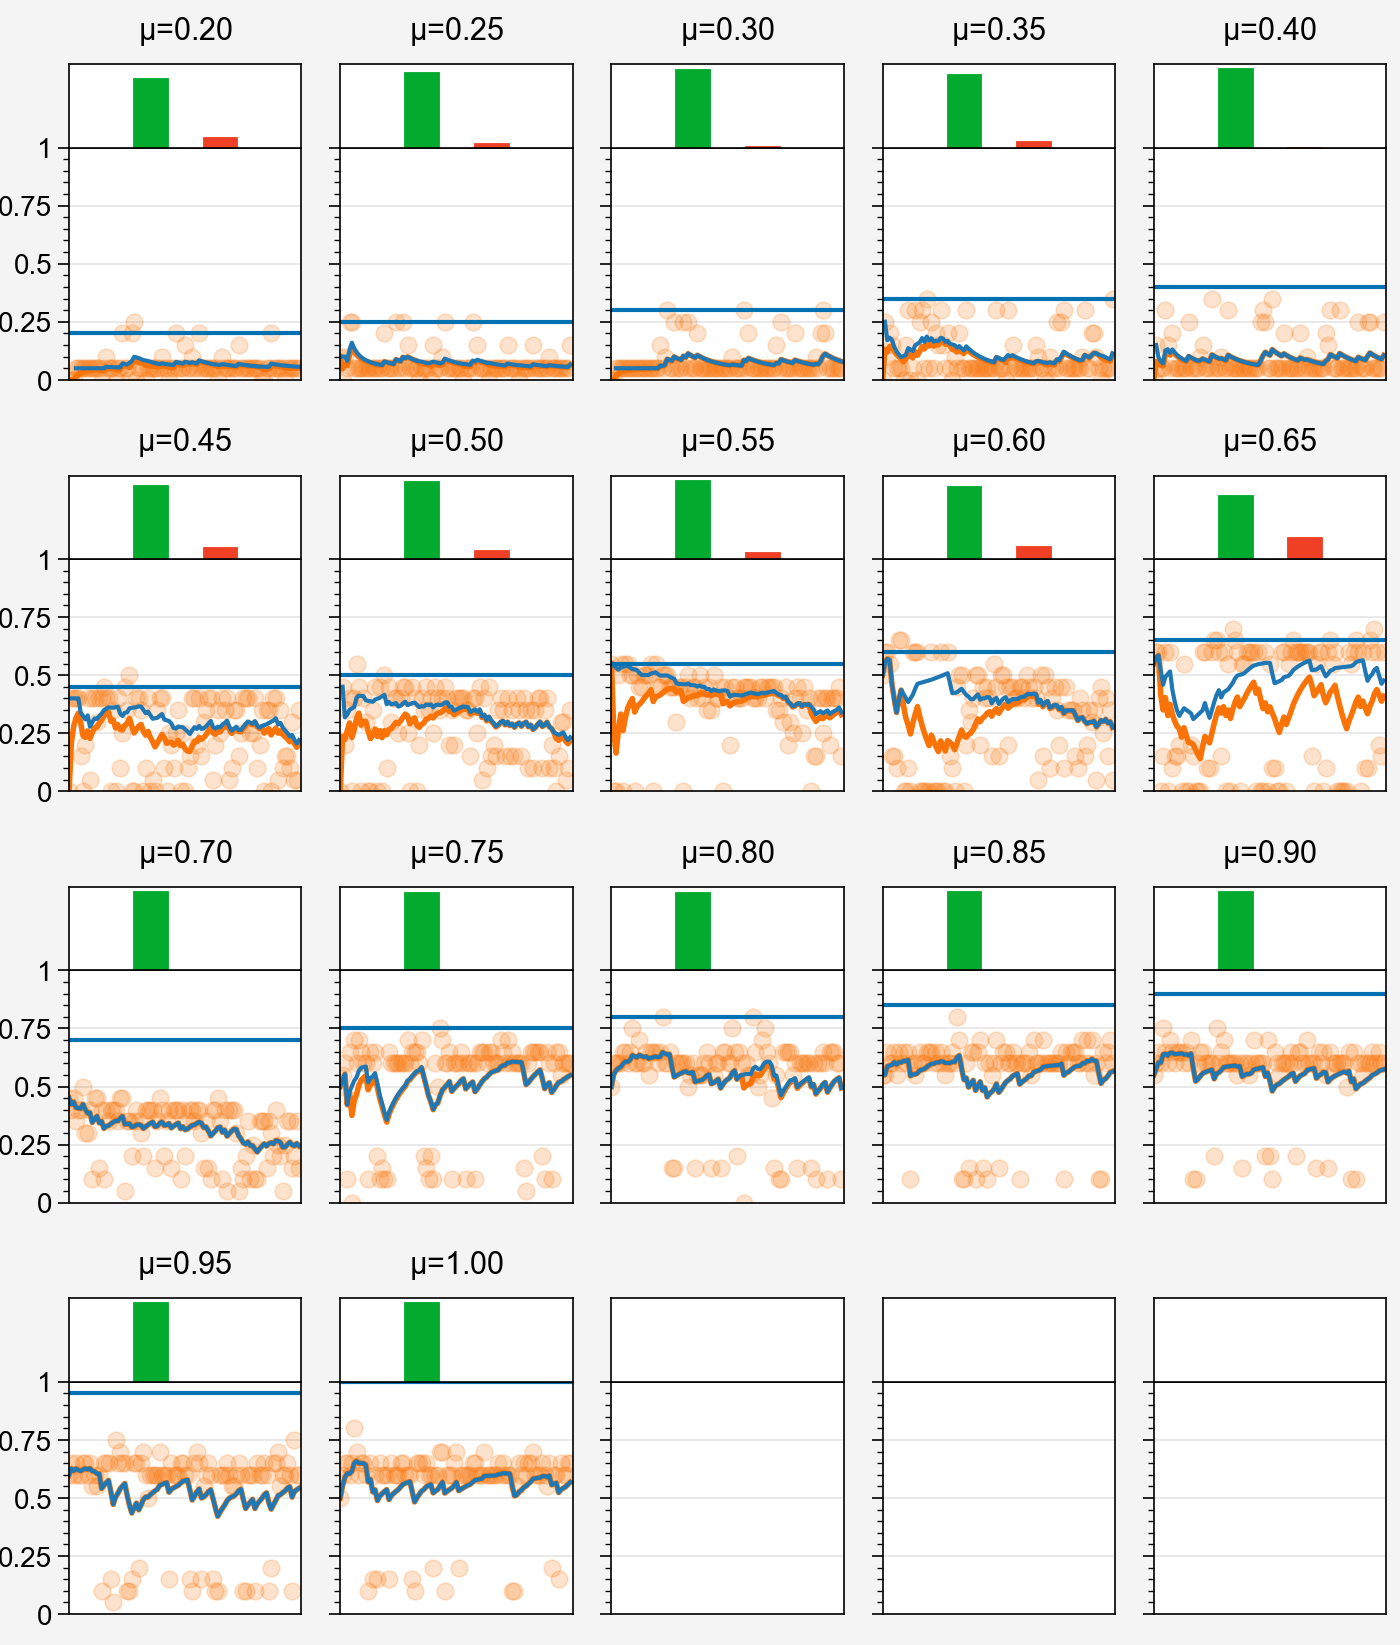

In [10]:
# model, (obs_rms, ret_rms) = \
#     torch.load(f'../saved_checkpoints/meta/meta_easyr4_0/60.pt')
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/p2n50pop0.1_1/160.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=100)
plot_1colornfsize(res)

In [25]:
decision_nodes, pos_scores, neg_scores, penult_steps = \
    find_decision_nodes(res, model, ep=15, full_ret=True)
decision_scores = np.vstack([pos_scores, neg_scores]).max(axis=0)
m = decision_scores.mean()
v = decision_scores.var()
print(f"mean: {m}, var: {v}")

mean: 0.03956068180443253, var: 0.0010590871069557943


In [11]:
decision_score_means = []
decision_score_vars = []
num_decision_nodes = []
impulsivity = []
for ep in range(17):
    decision_nodes, pos_scores, neg_scores, penult_steps = \
        find_decision_nodes(res, model, ep=ep, full_ret=True)
    decision_scores = np.vstack([pos_scores, neg_scores]).max(axis=0)
    m = decision_scores.mean()
    v = decision_scores.var()
    
    decision_score_means.append(m)
    decision_score_vars.append(v)
    num_decision_nodes.append(np.sum(decision_nodes))
    ap = res['action_probs'][ep][:, 1]
    impulsivity.append(((ap > 0.1) & (ap < 0.5)).sum() / (ap < 0.5).sum())

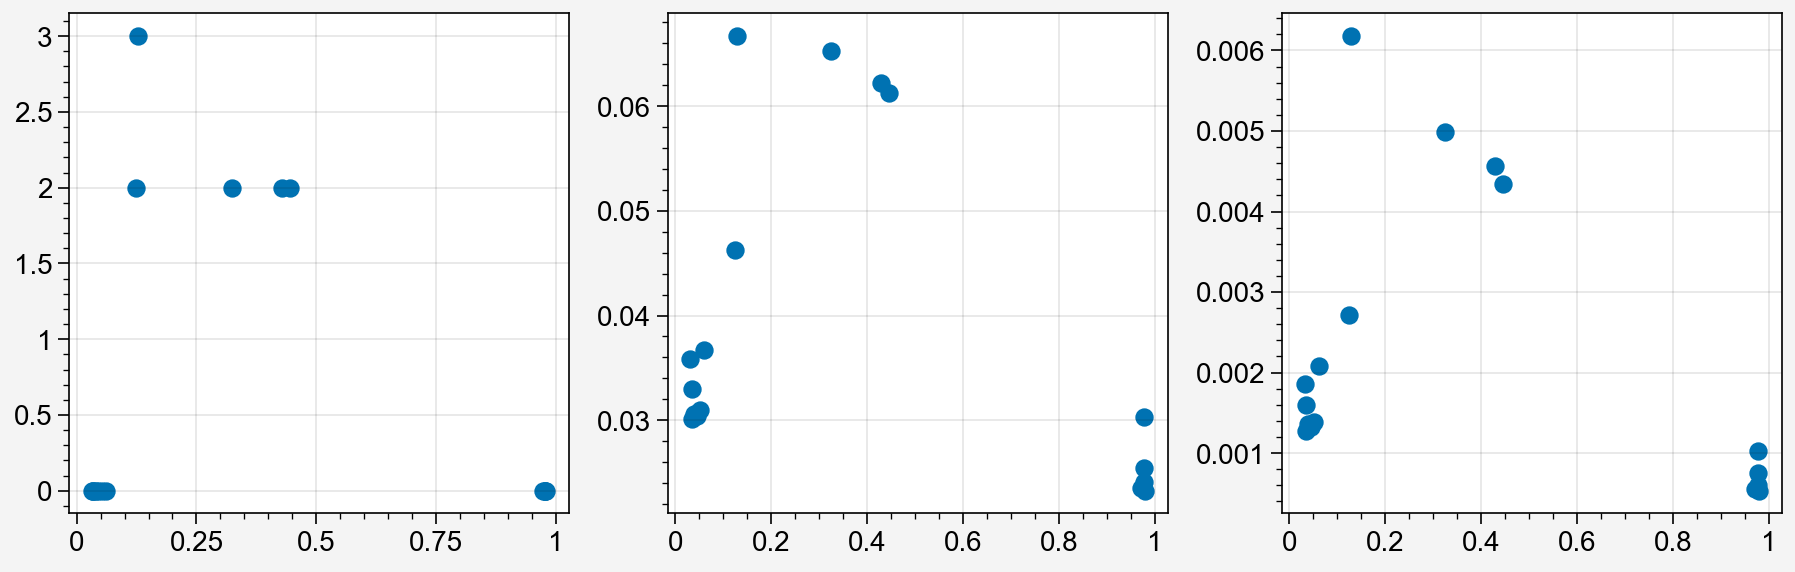

In [12]:
fig, ax = pplt.subplots(ncols=3, sharey=False)
ax[0].scatter(impulsivity, num_decision_nodes)
ax[1].scatter(impulsivity, decision_score_means)
ax[2].scatter(impulsivity, decision_score_vars)

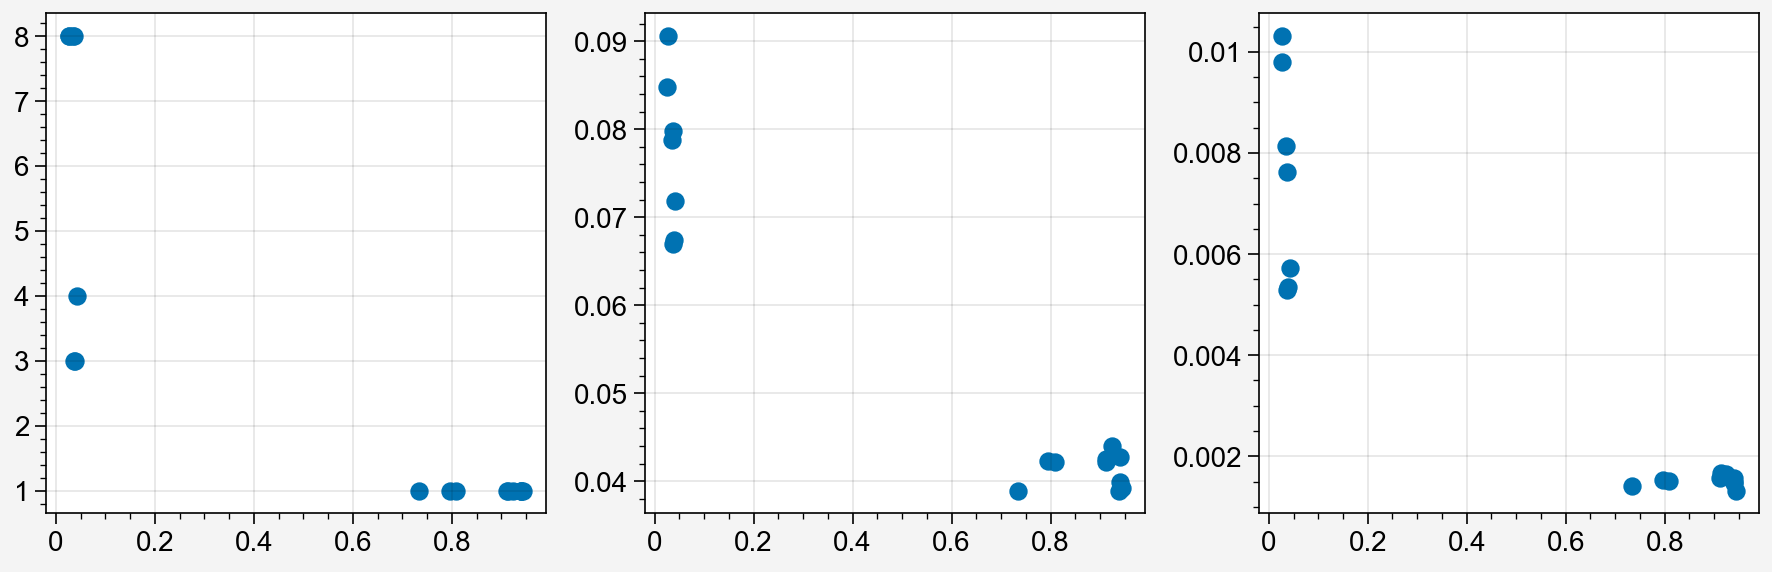

In [7]:
fig, ax = pplt.subplots(ncols=3, sharey=False)
ax[0].scatter(impulsivity, num_decision_nodes)
ax[1].scatter(impulsivity, decision_score_means)
ax[2].scatter(impulsivity, decision_score_vars)

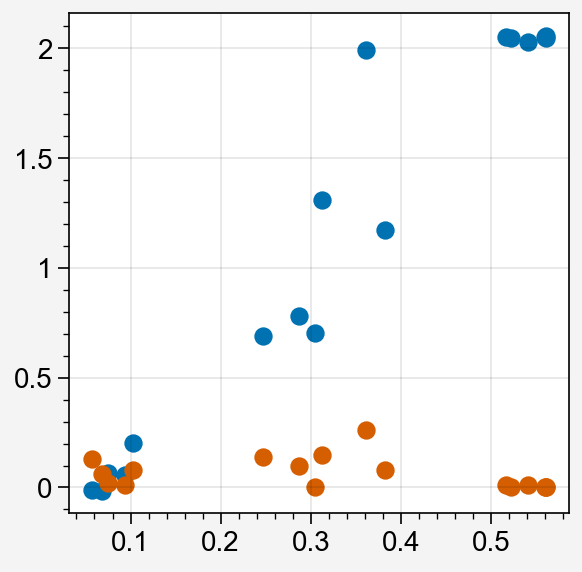

In [25]:
fig, ax = pplt.subplots()
mean_values = [v.mean() for v in res['values']]
mean_sizes = [np.mean(s) for s in res['data']['last_size']]
mean_pops = [np.sum(p)/100 for p in res['data']['popped']]
ax.scatter(mean_sizes, mean_values)
ax.scatter(mean_sizes, mean_pops)

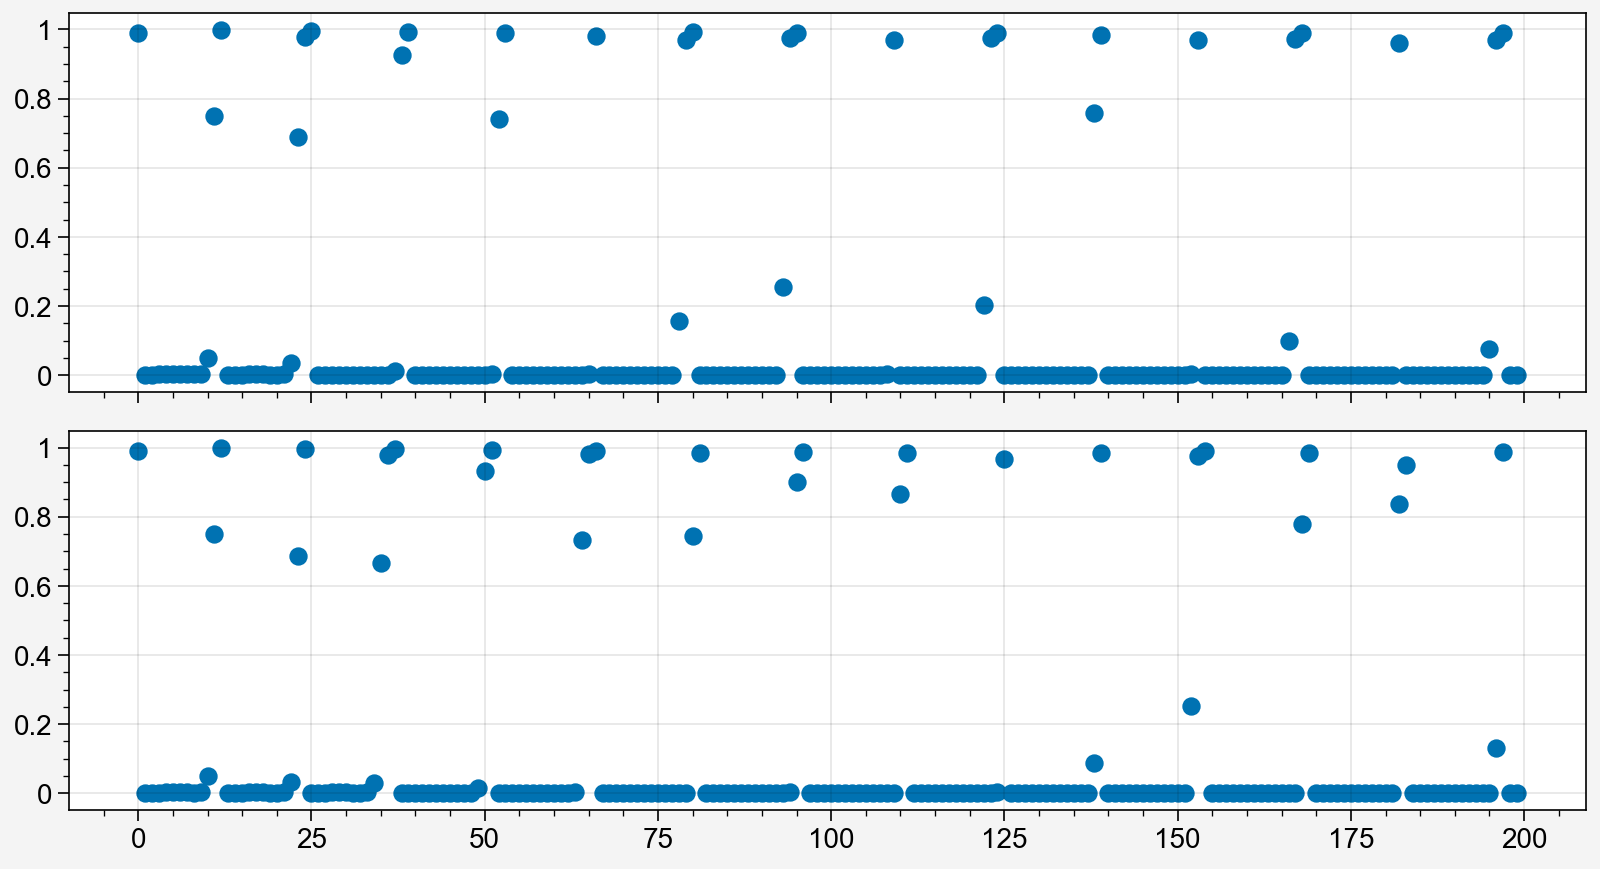

In [49]:
fig, ax = pplt.subplots(nrows=2, refaspect=4, figwidth=8)
eps = [10, 11]
for i, ep in enumerate(eps):
    ap = res['action_probs'][ep][:, 1]
    ax[i].scatter(ap[:200])

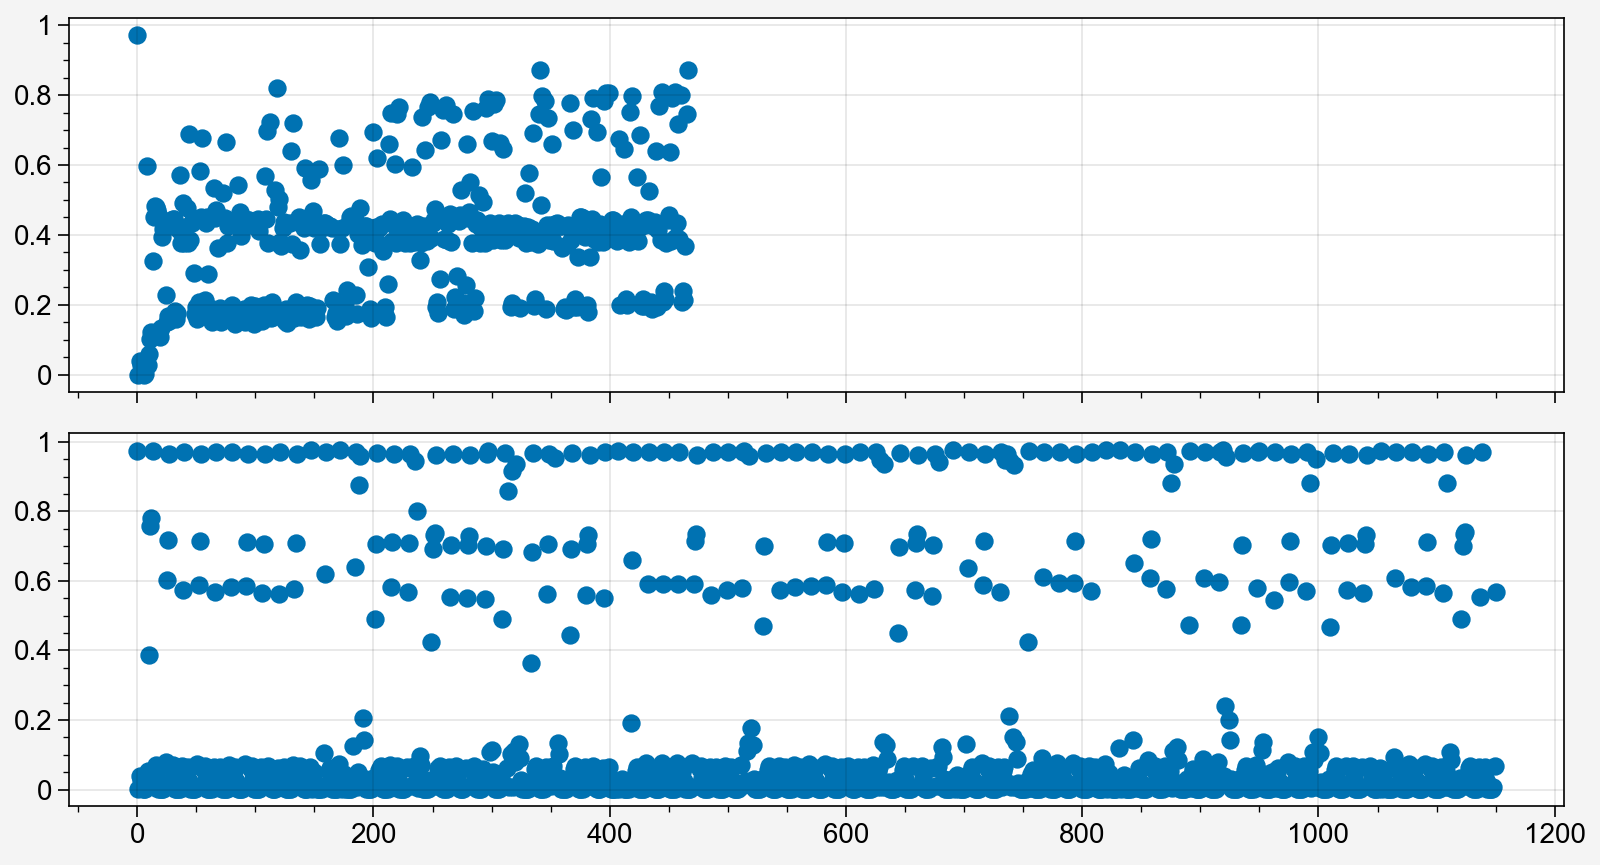

In [13]:
fig, ax = pplt.subplots(nrows=2, refaspect=4, figwidth=8)
eps = [3, 15]
for i, ep in enumerate(eps):
    ap = res['action_probs'][ep][:, 1]
    ax[i].scatter(ap)

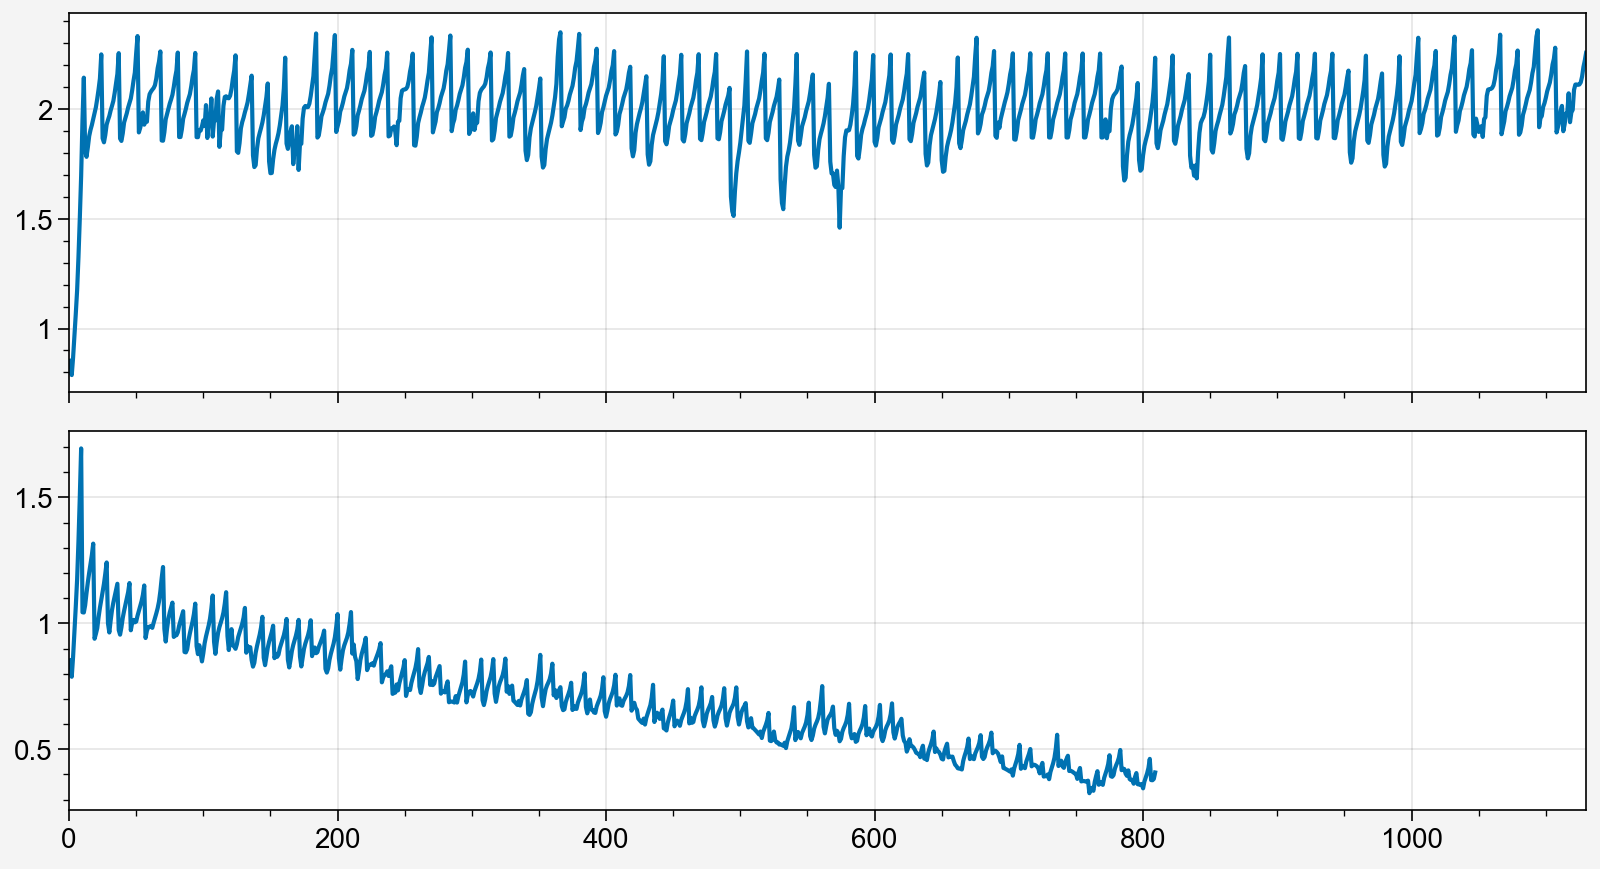

In [26]:
fig, ax = pplt.subplots(nrows=2, refaspect=4, figwidth=8)
eps = [9, 10]
for i, ep in enumerate(eps):
    value = res['values'][ep]
    ax[i].plot(value)

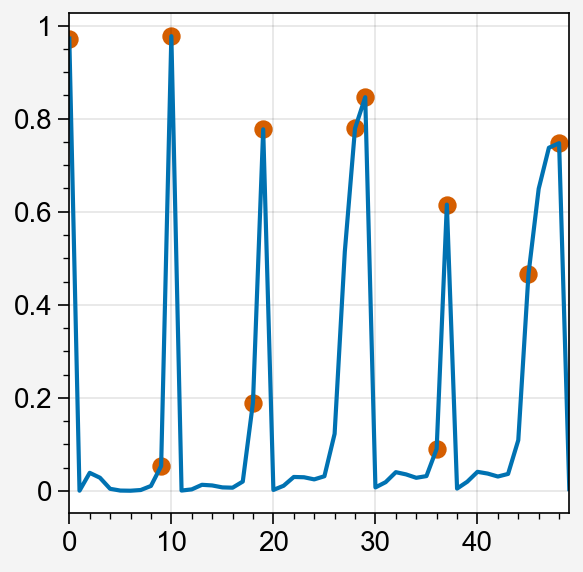

In [33]:
ep = 10
fig, ax = pplt.subplots()
presses = np.argwhere(res['actions'][ep][:50].reshape(-1) == 1).reshape(-1)
ap = res['action_probs'][ep][:50, 1]
ax.plot(ap)
ax.scatter(presses, ap[presses])

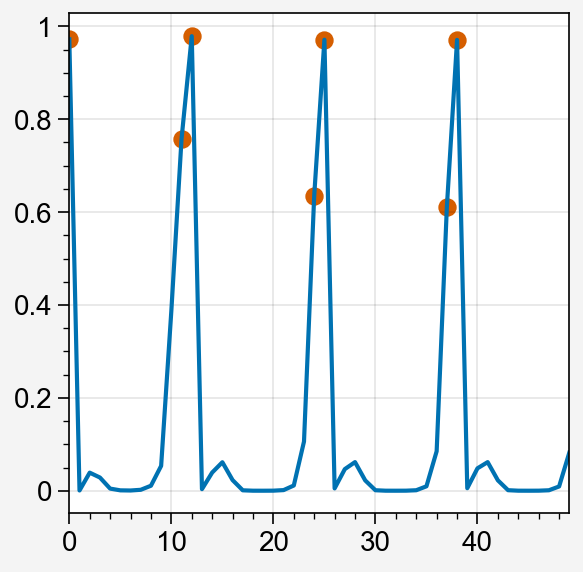

In [34]:
ep = 9
fig, ax = pplt.subplots()
presses = np.argwhere(res['actions'][ep][:50].reshape(-1) == 1).reshape(-1)
ap = res['action_probs'][ep][:50, 1]
ax.plot(ap)
ax.scatter(presses, ap[presses])

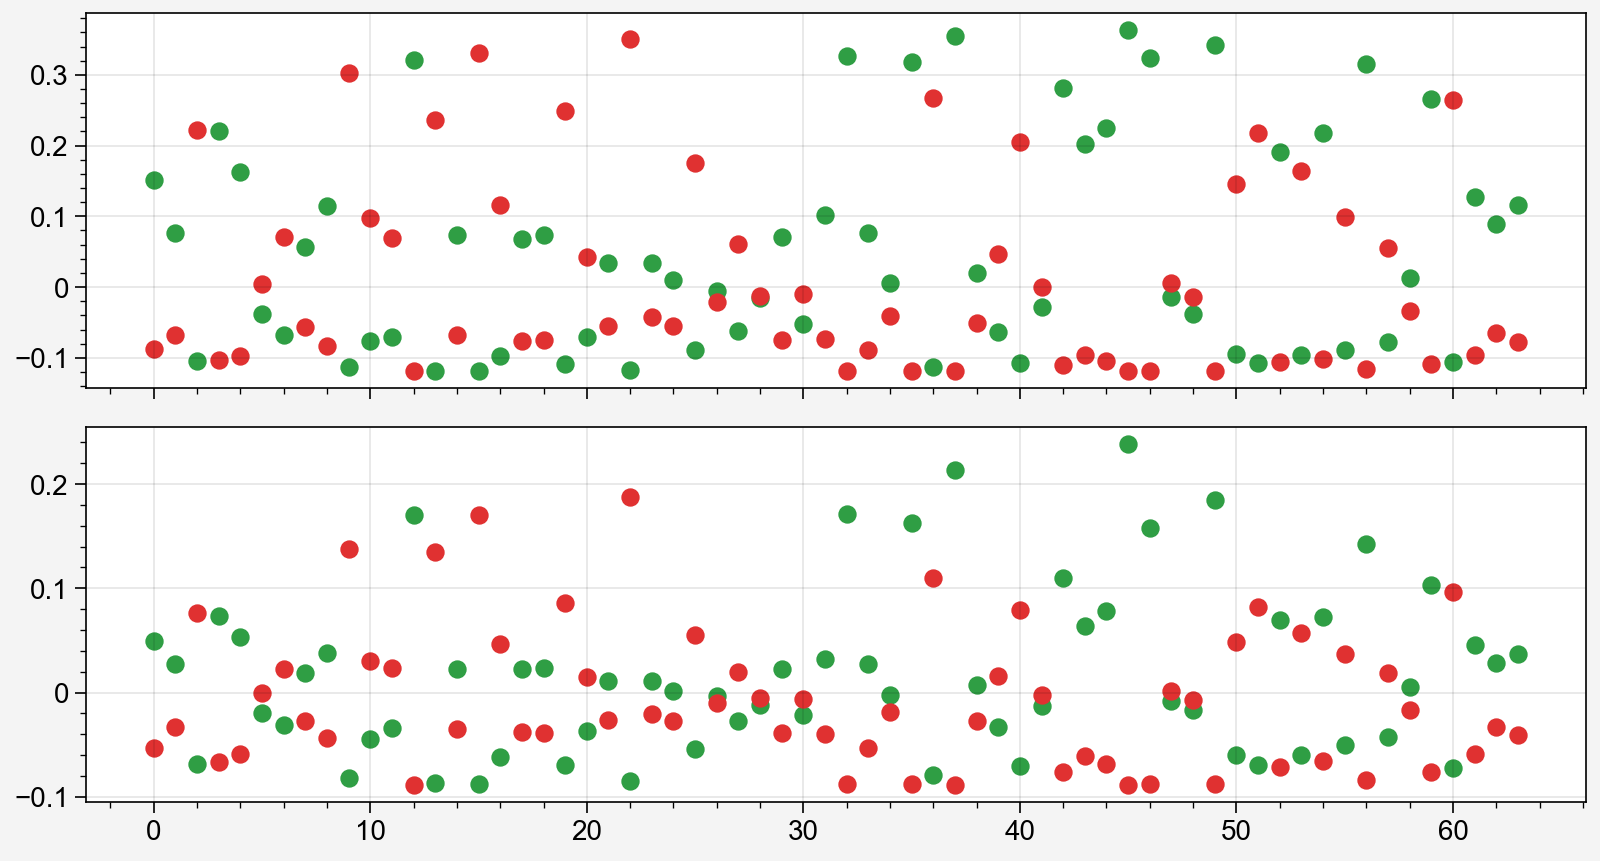

In [54]:
fig, ax = pplt.subplots(nrows=2, refaspect=4, figwidth=8)
for i, ep in enumerate(eps):
    decision_nodes, pos_scores, neg_scores, penult_steps = \
        find_decision_nodes(res, model, ep=ep, full_ret=True)
    decision_scores = np.vstack([pos_scores, neg_scores]).max(axis=0)
    ax[i].scatter(pos_scores, c='green8')
    ax[i].scatter(neg_scores, c='red8')

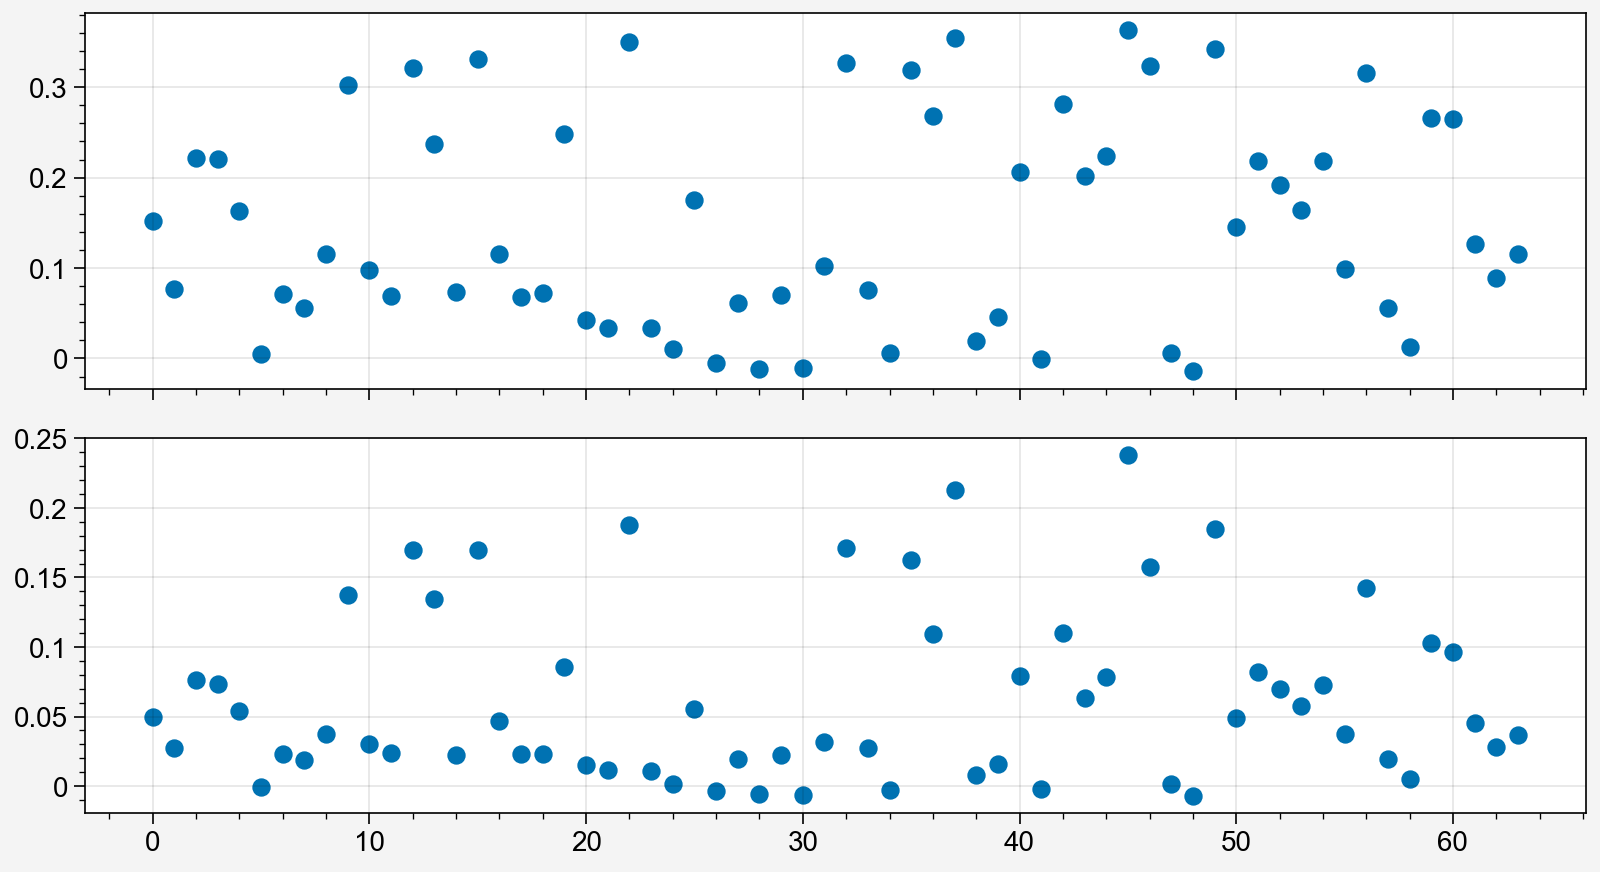

In [55]:
fig, ax = pplt.subplots(nrows=2, refaspect=4, figwidth=8)
for i, ep in enumerate(eps):
    decision_nodes, pos_scores, neg_scores, penult_steps = \
        find_decision_nodes(res, model, ep=ep, full_ret=True)
    decision_scores = np.vstack([pos_scores, neg_scores]).max(axis=0)
    ax[i].scatter(decision_scores)

# Manifold dynamics

In [4]:
size = np.arange(0.2, 1.01, 0.05)
env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 40,
                            'inflate_noise': 0,
                            'fix_sizes': [0, s, 0]} for s in size]

evalu = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                num_processes=17,
                seed=1,
                deterministic=False,
                with_activations=True)

In [8]:
# model, (obs_rms, ret_rms) = \
#     torch.load(f'../saved_checkpoints/meta/meta_easyr4_0/60.pt')
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/p2n50pop0.1_1/160.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)
# plot_1colornfsize(res)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


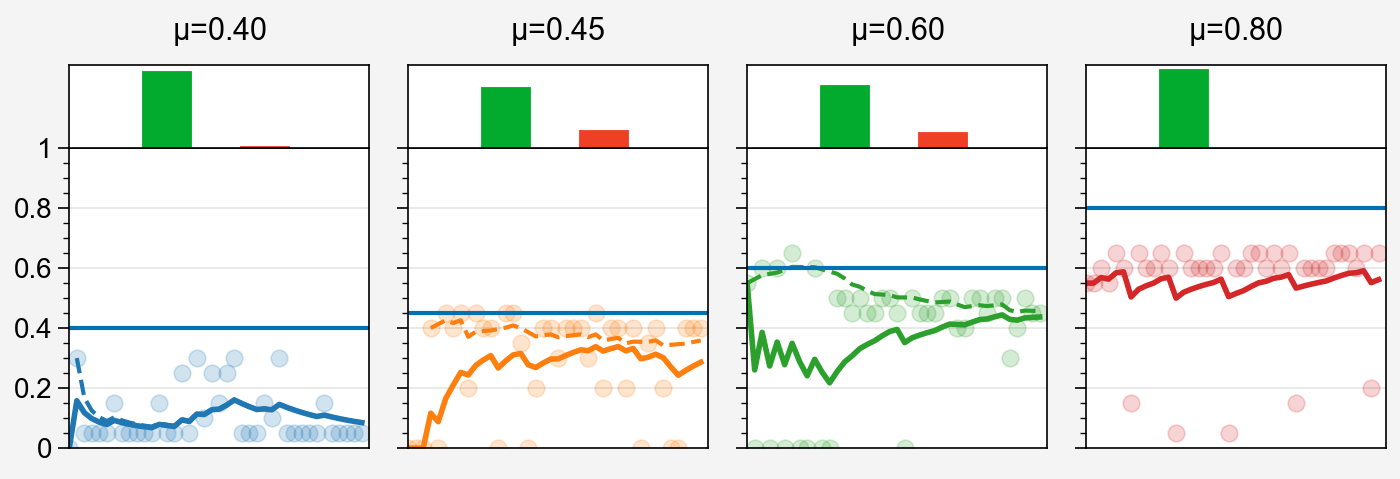

In [9]:
eps = [4, 5, 8, 12]
plot_1colornfsize(res, eps=eps, diff_colors=True)

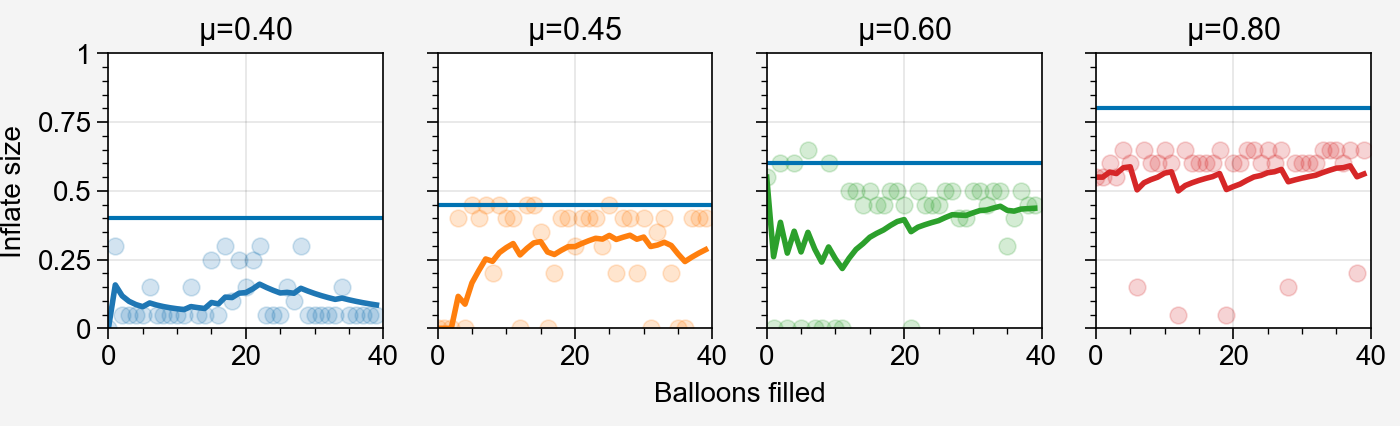

In [15]:
eps = [4, 5, 8, 12]
fig, ax = plot_1colornfsize(res, eps=eps, diff_colors=True, 
                            plot_pops=False, plot_both_means=False)
ax.format(xlabel='Balloons filled', ylabel='Inflate size')

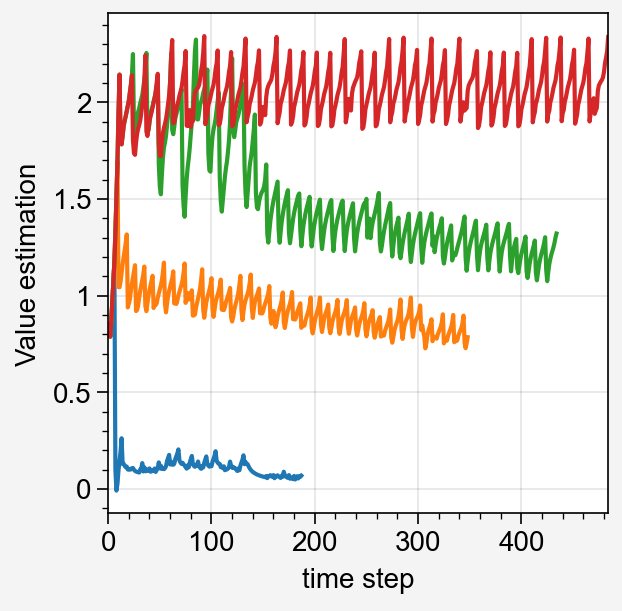

In [45]:
fig, ax = pplt.subplots()
for i, ep in enumerate(eps):
    values = res['values'][ep]
    ax.plot(values, color=rgb_colors[i])
    
ax.format(xlabel='time step', ylabel='Value estimation')

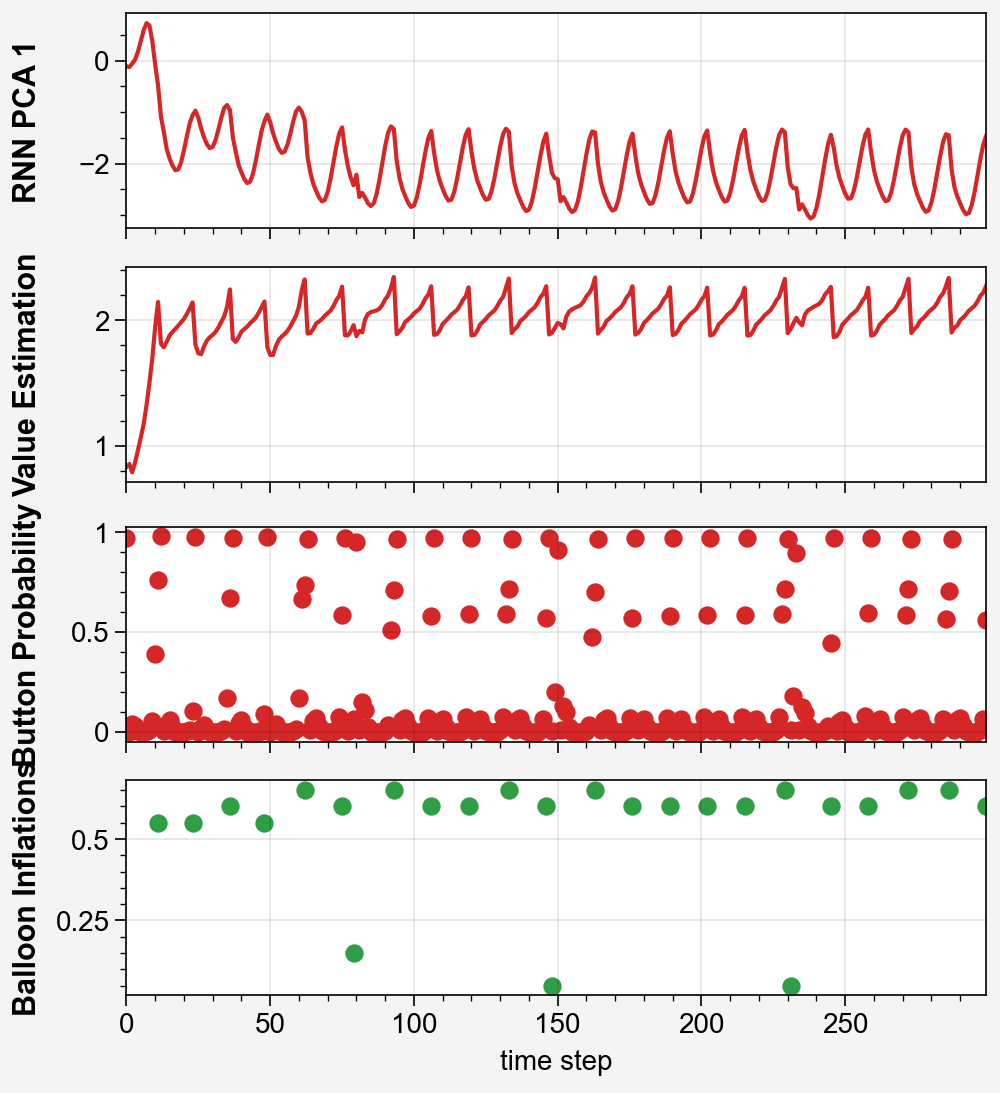

In [77]:
fig, ax = pplt.subplots(nrows=4, refaspect=4, figwidth=5)
ep = 12
c = rgb_colors[3]
step1 = 0
step2 = step1+300


balloon_step = np.array(res['data']['balloon_step'][ep])
inflate_times = np.array(res['data']['last_size'][ep])
popped = np.array(res['data']['popped'][ep])
use_balloon_steps = (balloon_step < step2) & (balloon_step > step1)
inflate_times = inflate_times[use_balloon_steps]
popped = popped[use_balloon_steps]
balloon_step = balloon_step[use_balloon_steps]

ax[0].plot(pca_as[ep][step1:step2, 0], c=c)
ax[1].plot(res['values'][ep][step1:step2], c=c)
ax[2].scatter(res['action_probs'][ep][step1:step2, 1], c=c)
ax[3].scatter(balloon_step[popped]-step1, inflate_times[popped], c='red8')
ax[3].scatter(balloon_step[~popped]-step1, inflate_times[~popped], c='green8')

ax.format(xlabel='time step', leftlabels=['RNN PCA 1', 'Value Estimation', 
                                          'Button Probability', 'Balloon Inflations'])

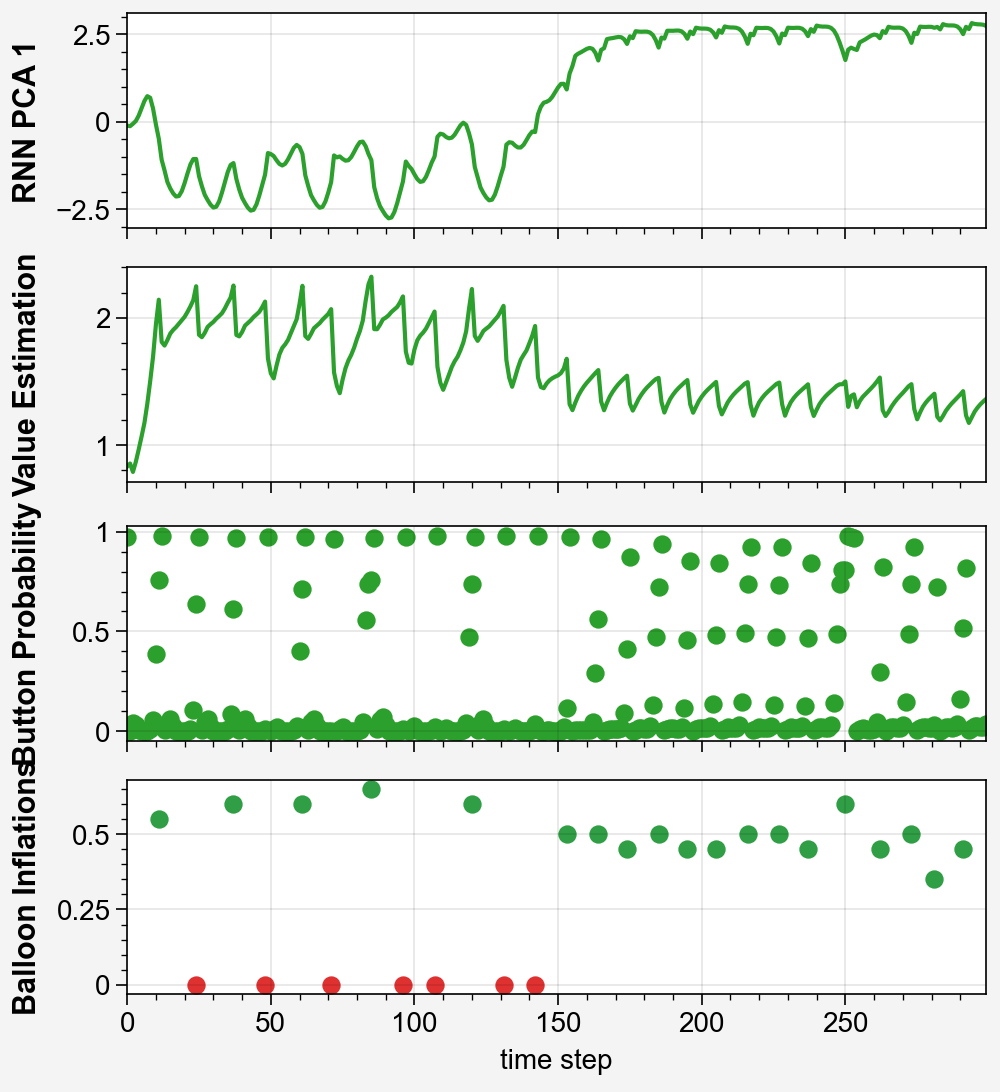

In [78]:
fig, ax = pplt.subplots(nrows=4, refaspect=4, figwidth=5)
ep = 8
step1 = 0
step2 = step1+300

c = rgb_colors[2]

balloon_step = np.array(res['data']['balloon_step'][ep])
inflate_times = np.array(res['data']['last_size'][ep])
popped = np.array(res['data']['popped'][ep])
use_balloon_steps = (balloon_step < step2) & (balloon_step > step1)
inflate_times = inflate_times[use_balloon_steps]
popped = popped[use_balloon_steps]
balloon_step = balloon_step[use_balloon_steps]

ax[0].plot(pca_as[ep][step1:step2, 0], c=c)
ax[1].plot(res['values'][ep][step1:step2], c=c)
ax[2].scatter(res['action_probs'][ep][step1:step2, 1], c=c)
ax[3].scatter(balloon_step[popped]-step1, inflate_times[popped], c='red8')
ax[3].scatter(balloon_step[~popped]-step1, inflate_times[~popped], c='green8')

ax.format(xlabel='time step', leftlabels=['RNN PCA 1', 'Value Estimation', 
                                          'Button Probability', 'Balloon Inflations'])

In [57]:
ep = 8
ap = res['action_probs'][ep][:, 1]

non_press_steps = (ap < 0.5) & (~presses)
print(ap[:150][non_press_steps[:150]].mean())
print(ap[150:][non_press_steps[150:]].mean())

0.022294194
0.042296667


In [59]:
ep = 12
ap = res['action_probs'][ep][:, 1]

presses = res['actions'][ep].reshape(-1) == 1
non_press_steps = (ap < 0.5) & (~presses)
print(ap[:150][non_press_steps[:150]].mean())
print(ap[150:][non_press_steps[150:]].mean())

0.025759857
0.026706304


In [76]:
import plotly.graph_objects as go

traces = []

step1 = 0
step2 = -1
for i, ep in enumerate(eps):
    pca_a = pca_as[ep]
    x, y, z = pca_a[step1:step2, 0], pca_a[step1:step2, 1], pca_a[step1:step2, 2]
    t = np.arange(len(x))
    size = unnormalize_obs(res['obs'][ep], obs_rms)[:, 5]
    size = size[step1:step2] 
    # Create a trace for the line
    trace = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=4,
            color=rgb_float_to_hex(rgb_colors[i]),
            # color=size,
            # colorscale='Plasma',
            # colorbar=dict(title='Size')
        ),
    )
    traces.append(trace)

# Create the layout
layout = go.Layout(
    title='3D Time Series Line Plot',
    width=800,
    height=800,
    scene=dict(
        xaxis_title='PCA 1',
        yaxis_title='PCA 2',
        zaxis_title='PCA 3'
    )
)

# Create the figure and add the trace
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

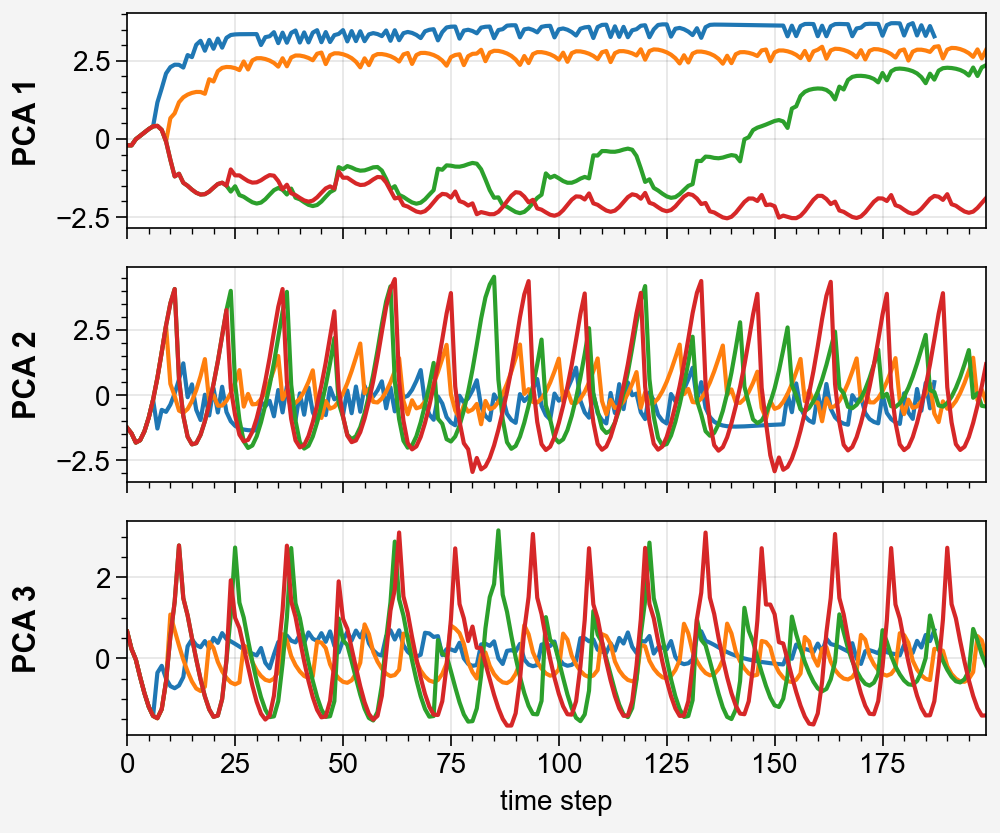

In [80]:

layer = 'shared1'
activ = res['activations'][layer]
ep_lens = [len(a) for a in activ]
all_activ = torch.vstack(activ)
pca = PCA(n_components=10)
all_pca_a = pca.fit_transform(all_activ)
pca_as = []

cur_step = 0
for ep_len in ep_lens:
    pca_as.append(all_pca_a[cur_step:cur_step+ep_len])
    cur_step += ep_len
fig, ax = pplt.subplots(refaspect=4, nrows=3, figwidth=5)
eps = [4, 5, 8, 12]
step2 = 200
for i in range(3):
    for j, ep in enumerate(eps):
        pca_a = pca_as[ep]
        ax[i].plot(pca_a[:step2, i], color=colors[j])
    
ax.format(leftlabels=['PCA 1', 'PCA 2', 'PCA 3'], xlabel='time step')


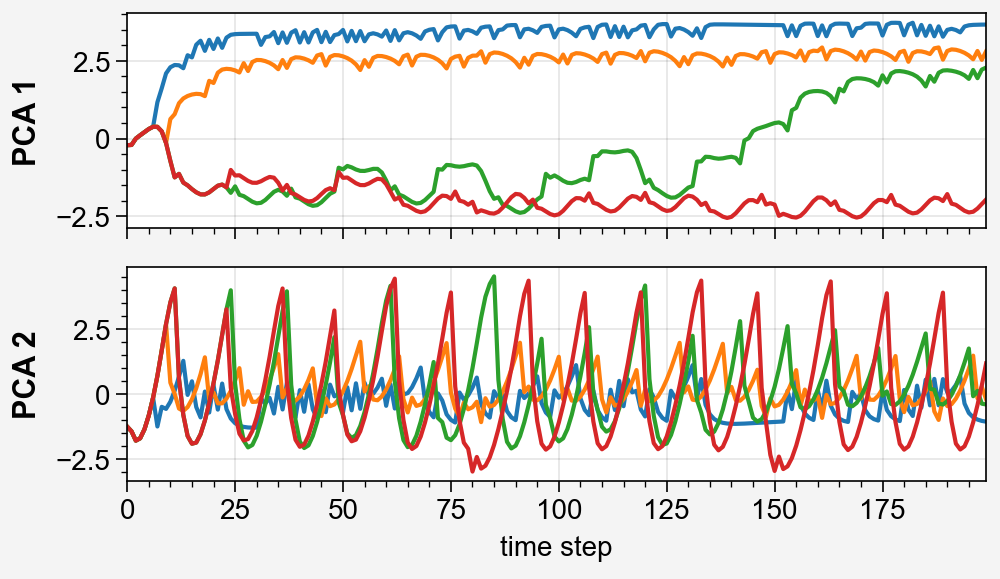

In [17]:

layer = 'shared1'
activ = res['activations'][layer]
ep_lens = [len(a) for a in activ]
all_activ = torch.vstack(activ)
pca = PCA(n_components=10)
all_pca_a = pca.fit_transform(all_activ)
pca_as = []

cur_step = 0
for ep_len in ep_lens:
    pca_as.append(all_pca_a[cur_step:cur_step+ep_len])
    cur_step += ep_len
fig, ax = pplt.subplots(refaspect=4, nrows=2, figwidth=5)
eps = [4, 5, 8, 12]
step2 = 200
for i in range(2):
    for j, ep in enumerate(eps):
        pca_a = pca_as[ep]
        ax[i].plot(pca_a[:step2, i], color=colors[j])
    
ax.format(leftlabels=['PCA 1', 'PCA 2'PCA 3'], xlabel='time step')


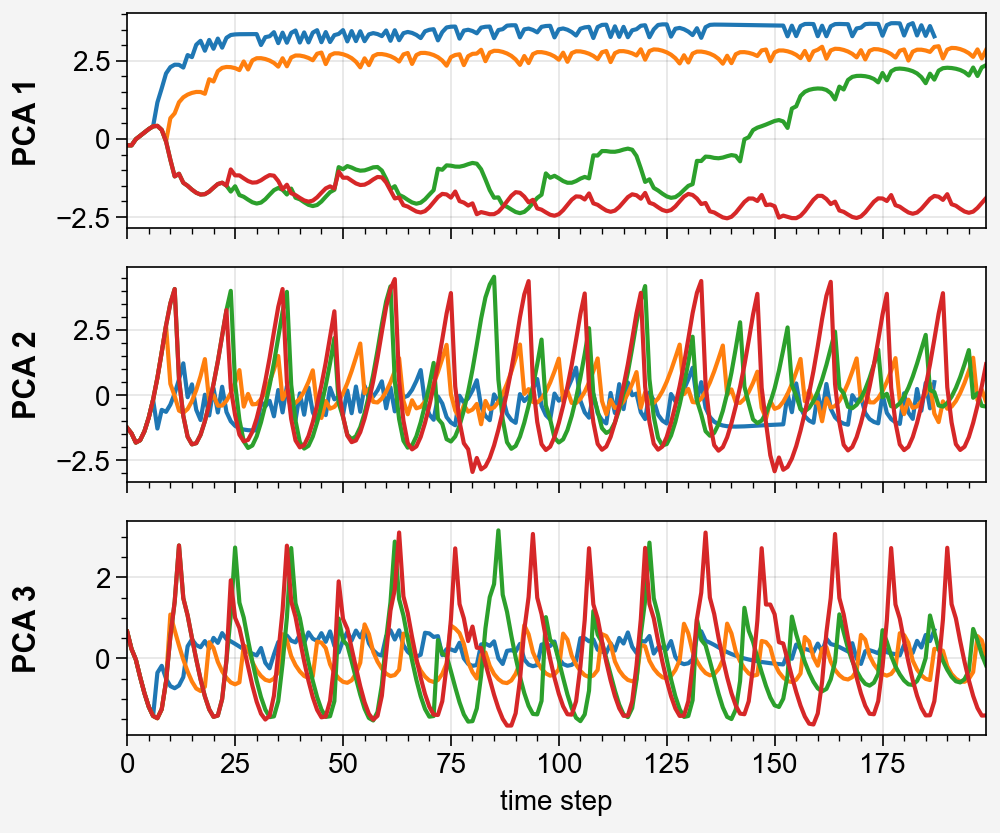

In [99]:

layer = 'shared1'
activ = res['activations'][layer]
ep_lens = [len(a) for a in activ]
all_activ = torch.vstack(activ)
pca = PCA(n_components=10)
all_pca_a = pca.fit_transform(all_activ)
pca_as = []

cur_step = 0
for ep_len in ep_lens:
    pca_as.append(all_pca_a[cur_step:cur_step+ep_len])
    cur_step += ep_len
fig, ax = pplt.subplots(refaspect=4, nrows=3, figwidth=5)
eps = [4, 5, 8, 12]
step2 = 200
for i in range(3):
    for j, ep in enumerate(eps):
        pca_a = pca_as[ep]
        ax[i].plot(pca_a[:step2, i], color=colors[j])
    
ax.format(leftlabels=['PCA 1', 'PCA 2', 'PCA 3'], xlabel='time step')


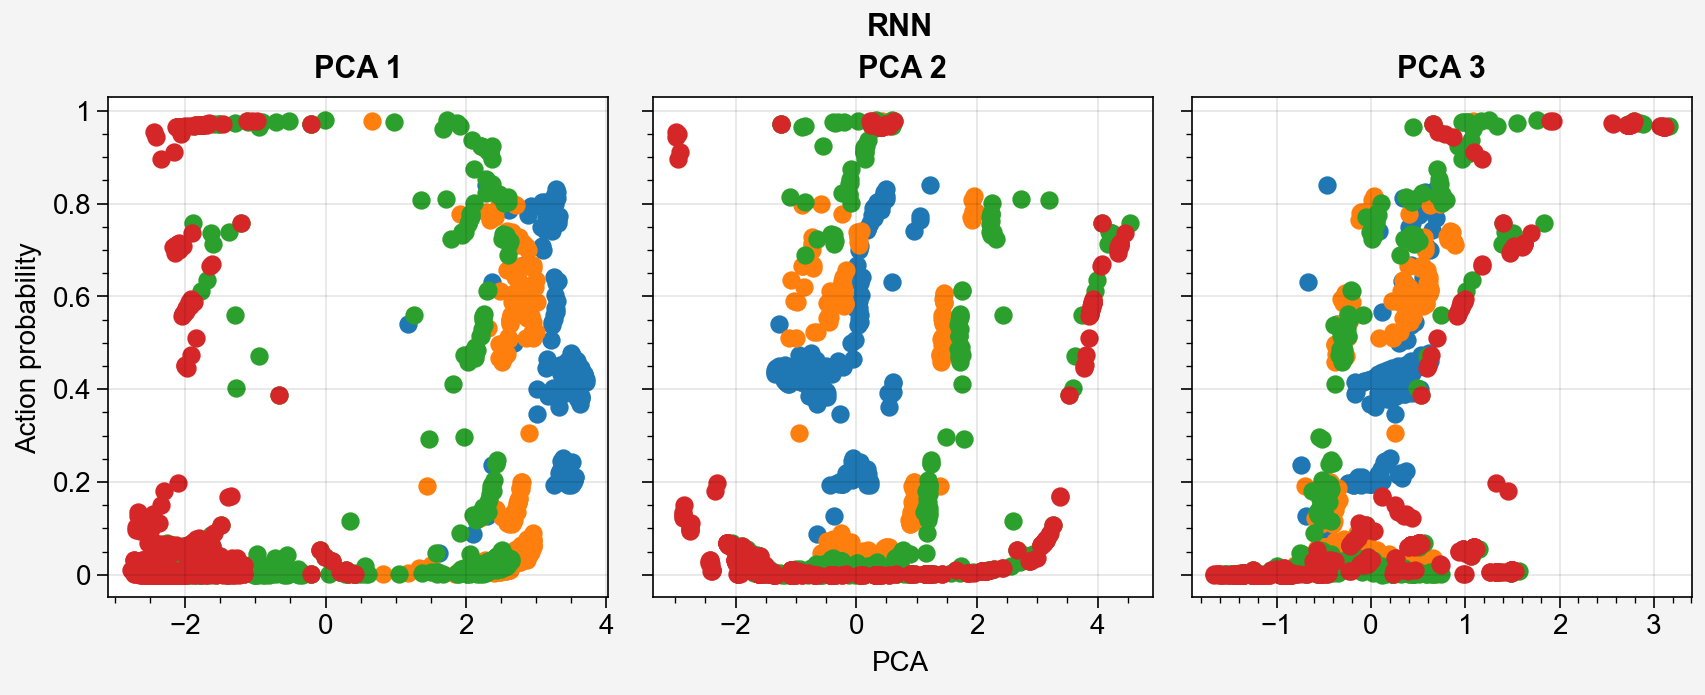

In [100]:
fig, ax = pplt.subplots(ncols=3)
for i in range(3):
    for j, ep in enumerate(eps):
        pca_a = pca_as[ep]
        ap = res['action_probs'][ep][:, 1]
        ax[i].scatter(pca_a[:, i], ap, c=rgb_colors[j])

ax.format(xlabel='PCA', ylabel='Action probability', toplabels=['PCA 1', 'PCA 2', 'PCA 3'],
          suptitle='RNN')

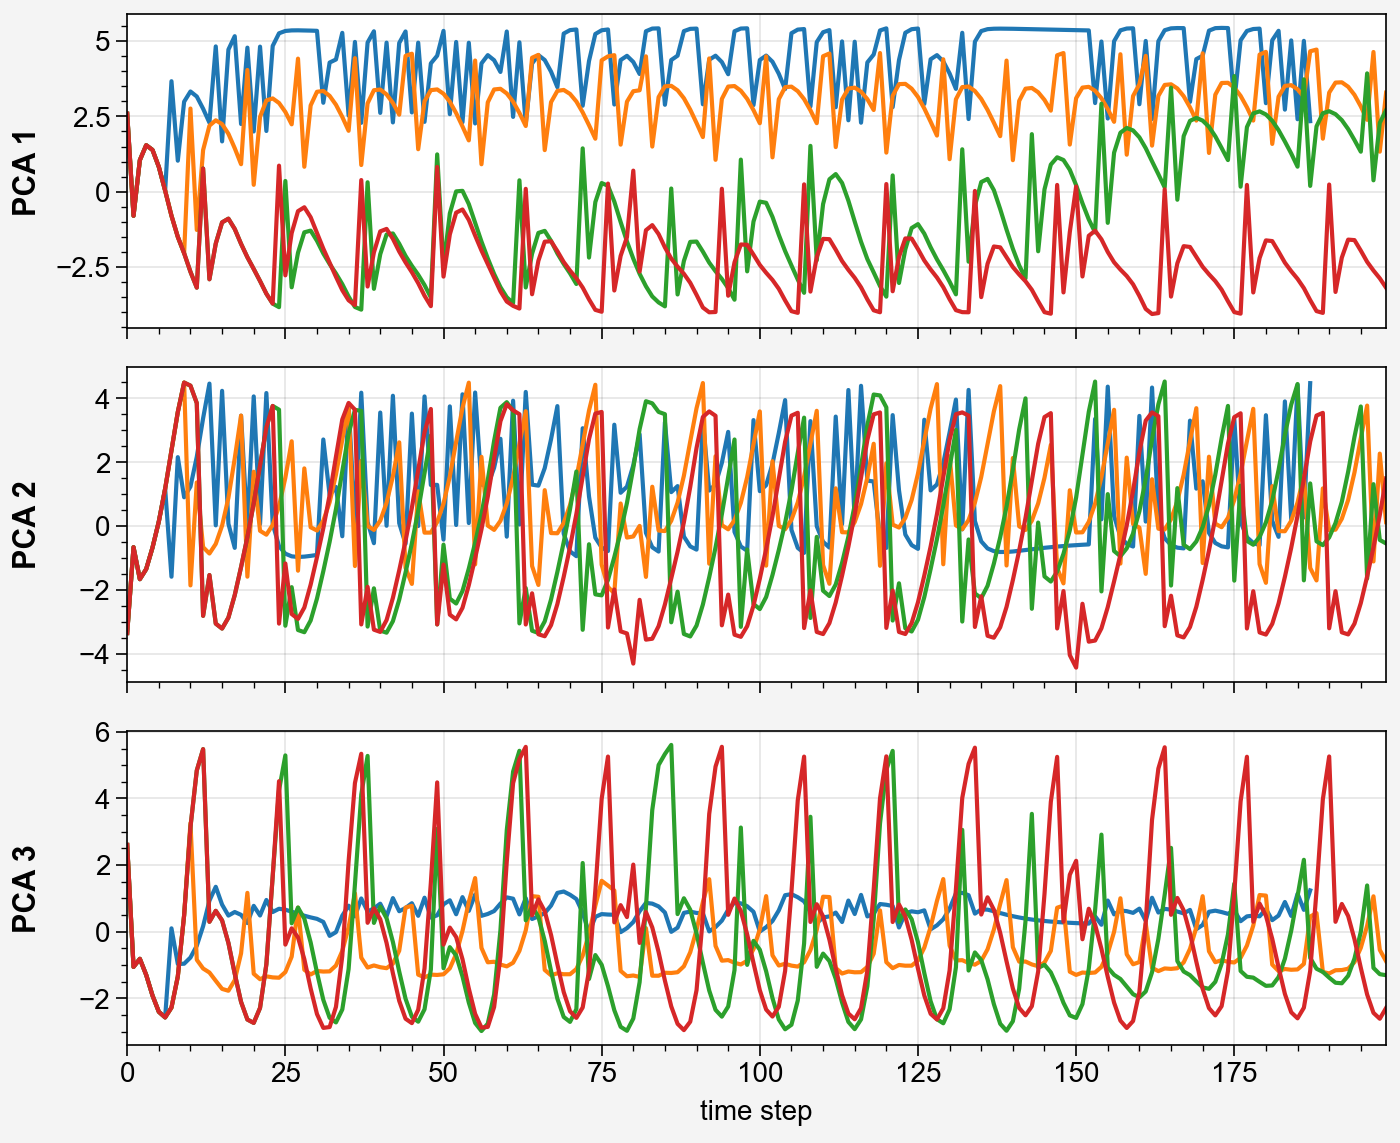

In [95]:

layer = 'actor0'
activ = res['activations'][layer]
ep_lens = [len(a) for a in activ]
all_activ = torch.vstack(activ)
pca = PCA(n_components=10)
all_pca_a = pca.fit_transform(all_activ)
pca_as = []

cur_step = 0
for ep_len in ep_lens:
    pca_as.append(all_pca_a[cur_step:cur_step+ep_len])
    cur_step += ep_len
fig, ax = pplt.subplots(refaspect=4, nrows=3, figwidth=7)
eps = [4, 5, 8, 12]
step2 = 200
for i in range(3):
    for j, ep in enumerate(eps):
        pca_a = pca_as[ep]
        ax[i].plot(pca_a[:step2, i], color=colors[j])
    
ax.format(leftlabels=['PCA 1', 'PCA 2', 'PCA 3'], xlabel='time step')


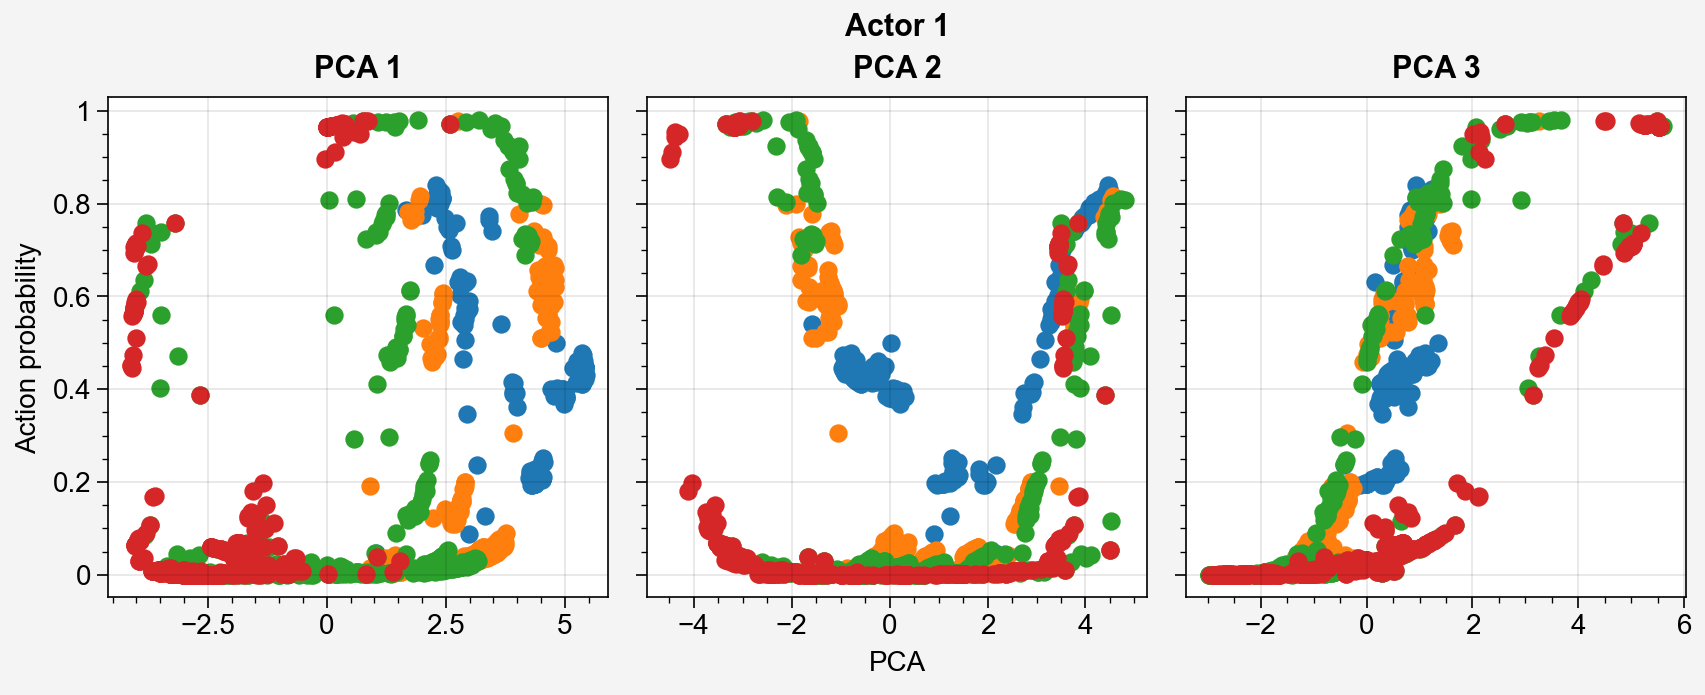

In [96]:
fig, ax = pplt.subplots(ncols=3)
for i in range(3):
    for j, ep in enumerate(eps):
        pca_a = pca_as[ep]
        ap = res['action_probs'][ep][:, 1]
        ax[i].scatter(pca_a[:, i], ap, c=rgb_colors[j])

ax.format(xlabel='PCA', ylabel='Action probability', toplabels=['PCA 1', 'PCA 2', 'PCA 3'],
          suptitle='Actor 1')

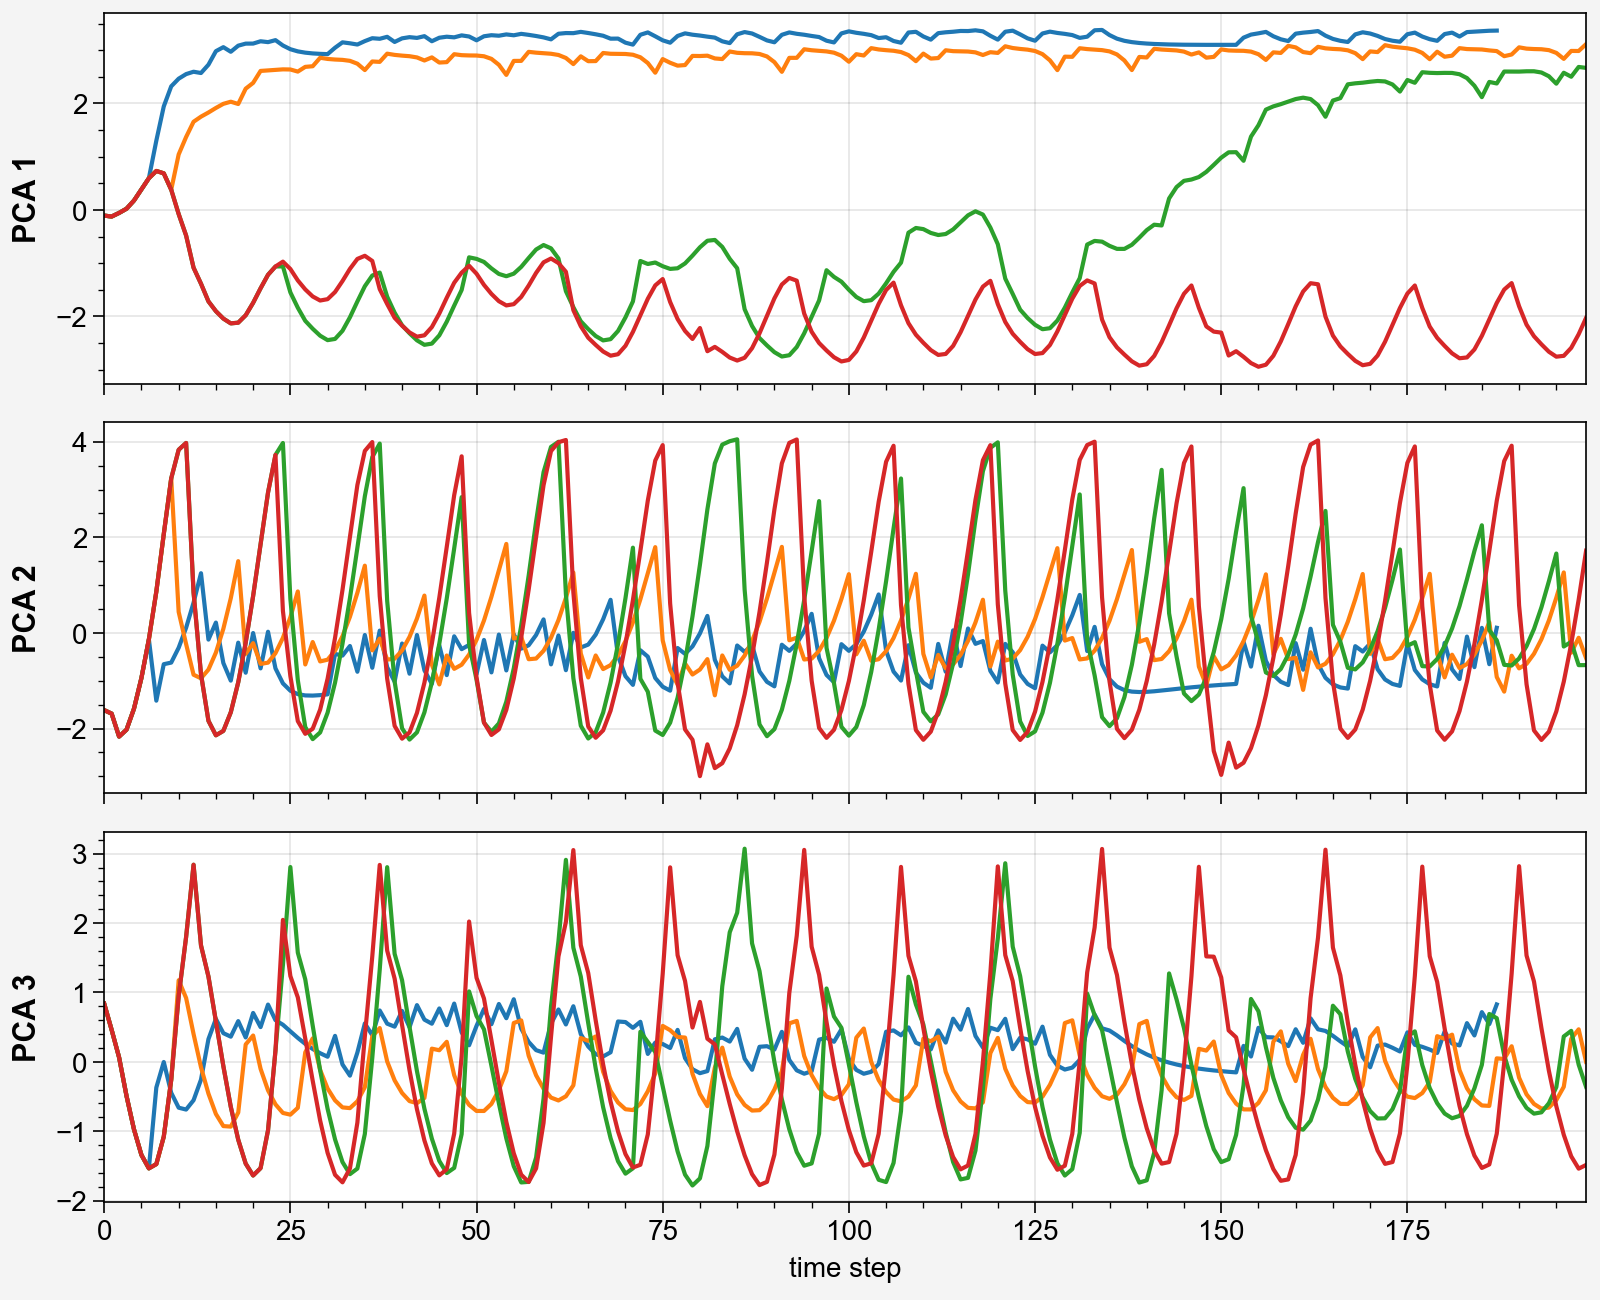

In [97]:

layer = 'critic0'
activ = res['activations'][layer]
ep_lens = [len(a) for a in activ]
all_activ = torch.vstack(activ)
pca = PCA(n_components=10)
all_pca_a = pca.fit_transform(all_activ)
pca_as = []

cur_step = 0
for ep_len in ep_lens:
    pca_as.append(all_pca_a[cur_step:cur_step+ep_len])
    cur_step += ep_len
fig, ax = pplt.subplots(refaspect=4, nrows=3, figwidth=8)
eps = [4, 5, 8, 12]
step2 = 200
for i in range(3):
    for j, ep in enumerate(eps):
        pca_a = pca_as[ep]
        ax[i].plot(pca_a[:step2, i], color=colors[j])
    
ax.format(leftlabels=['PCA 1', 'PCA 2', 'PCA 3'], xlabel='time step')


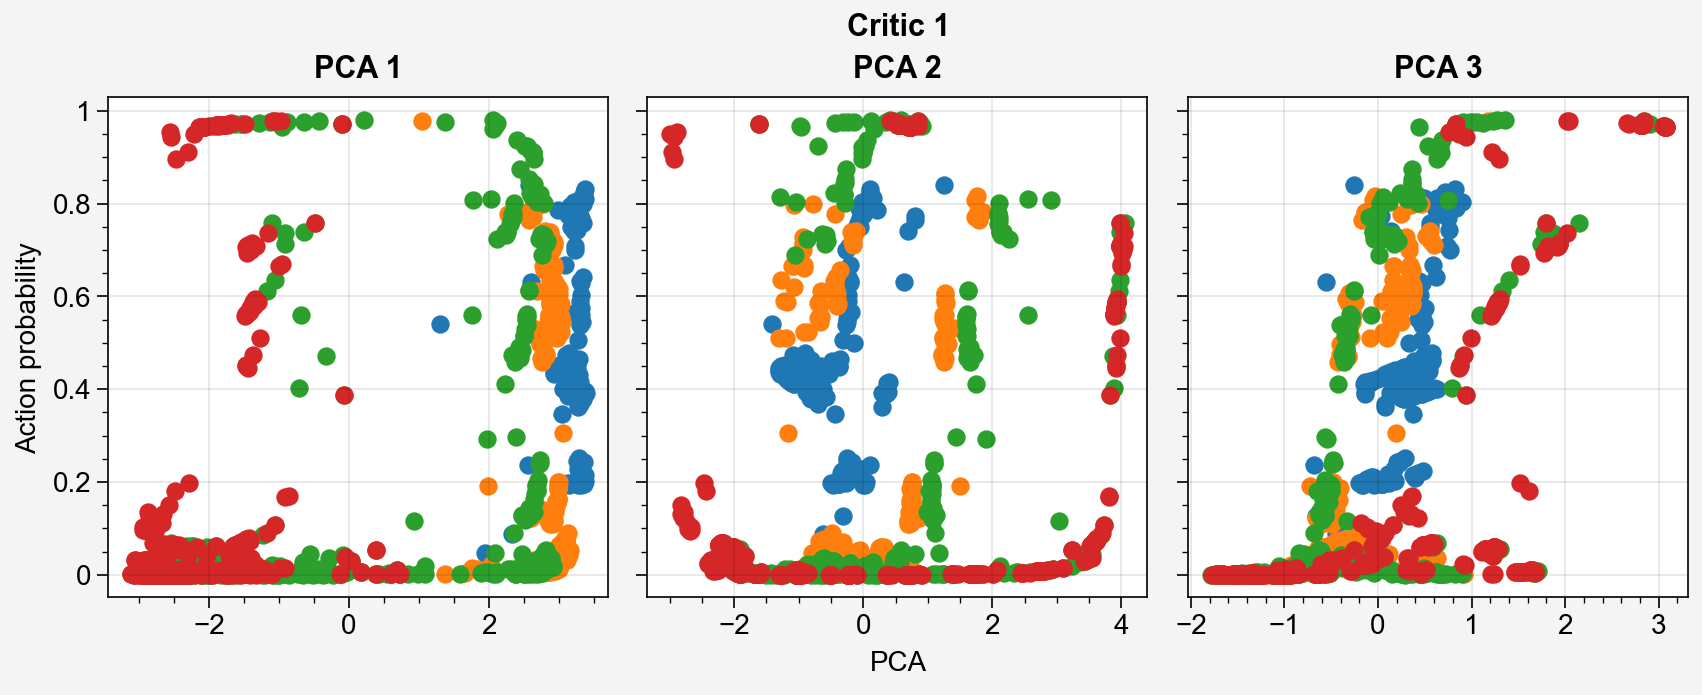

In [98]:
fig, ax = pplt.subplots(ncols=3)
for i in range(3):
    for j, ep in enumerate(eps):
        pca_a = pca_as[ep]
        ap = res['action_probs'][ep][:, 1]
        ax[i].scatter(pca_a[:, i], ap, c=rgb_colors[j])

ax.format(xlabel='PCA', ylabel='Action probability', toplabels=['PCA 1', 'PCA 2', 'PCA 3'],
          suptitle='Critic 1')

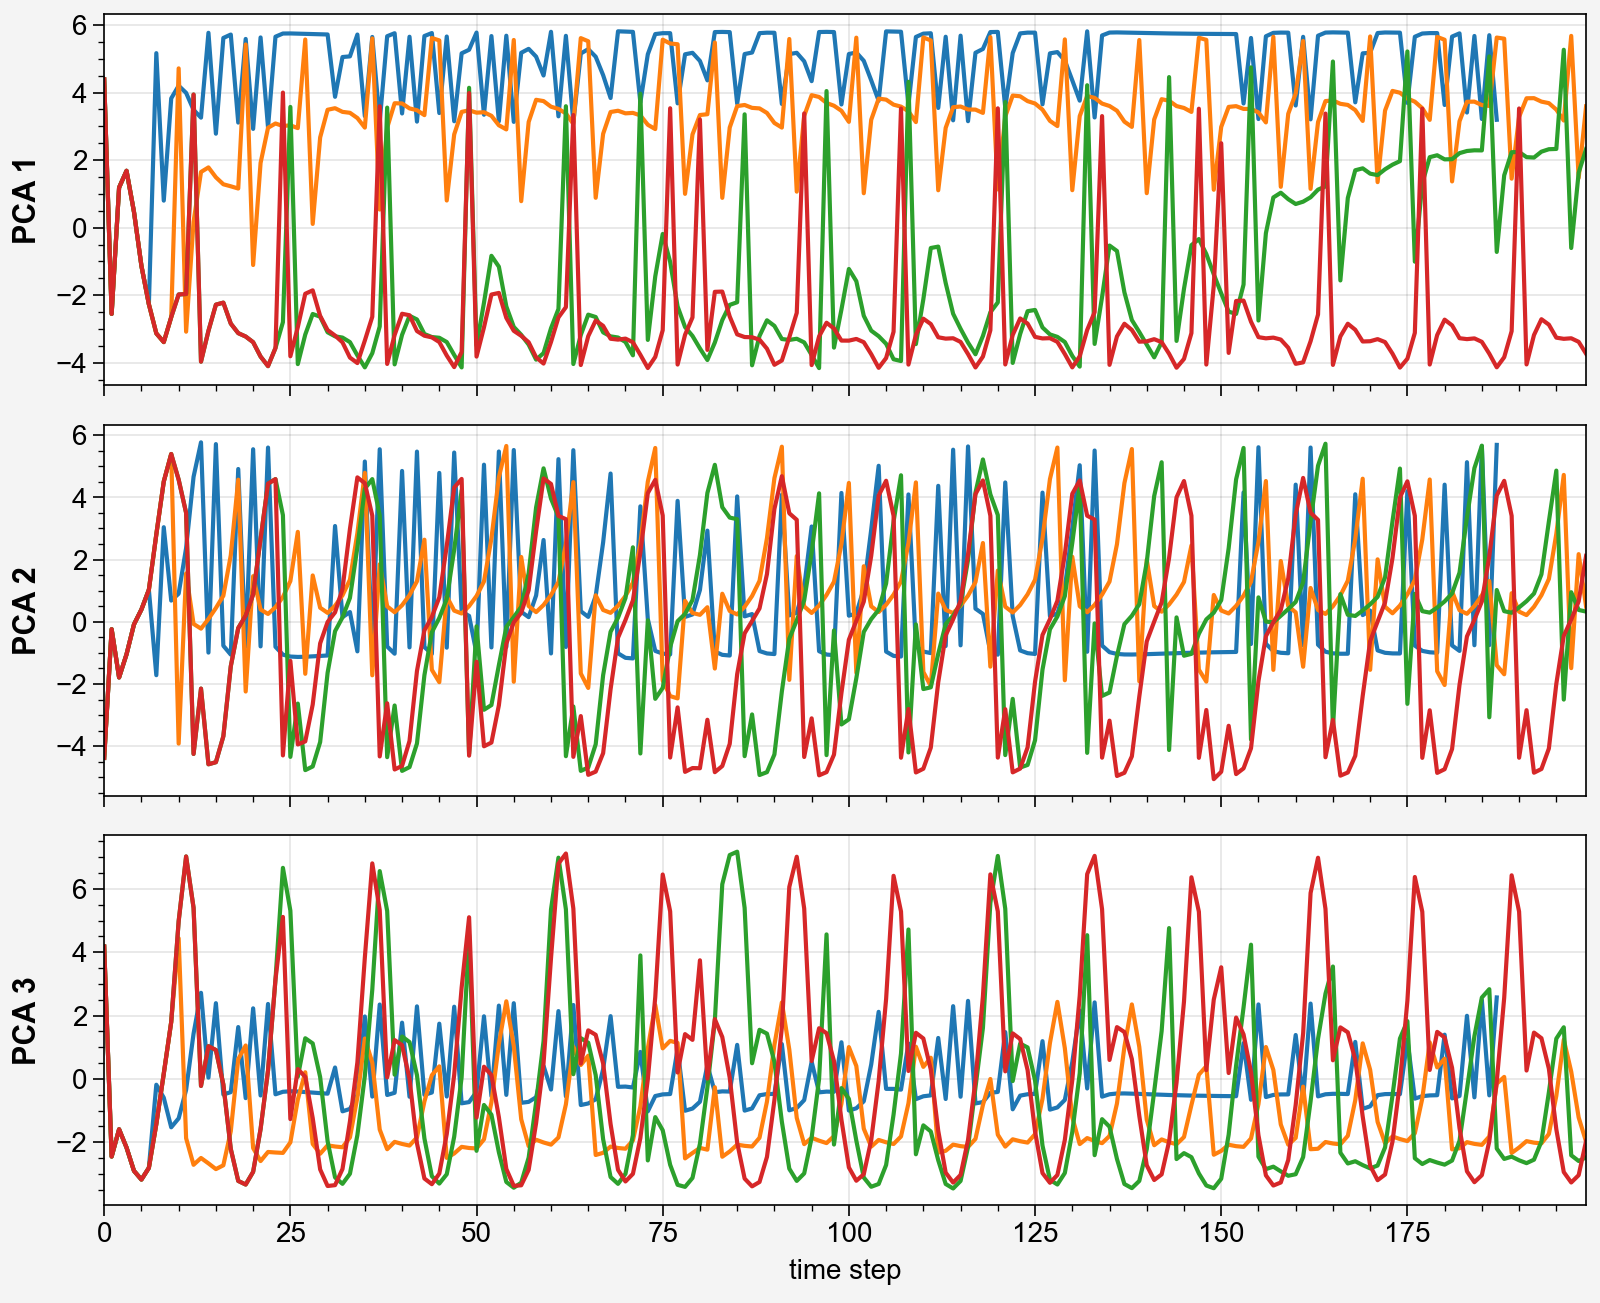

In [101]:

layer = 'actor1'
activ = res['activations'][layer]
ep_lens = [len(a) for a in activ]
all_activ = torch.vstack(activ)
pca = PCA(n_components=10)
all_pca_a = pca.fit_transform(all_activ)
pca_as = []

cur_step = 0
for ep_len in ep_lens:
    pca_as.append(all_pca_a[cur_step:cur_step+ep_len])
    cur_step += ep_len
fig, ax = pplt.subplots(refaspect=4, nrows=3, figwidth=8)
eps = [4, 5, 8, 12]
step2 = 200
for i in range(3):
    for j, ep in enumerate(eps):
        pca_a = pca_as[ep]
        ax[i].plot(pca_a[:step2, i], color=colors[j])
    
ax.format(leftlabels=['PCA 1', 'PCA 2', 'PCA 3'], xlabel='time step')


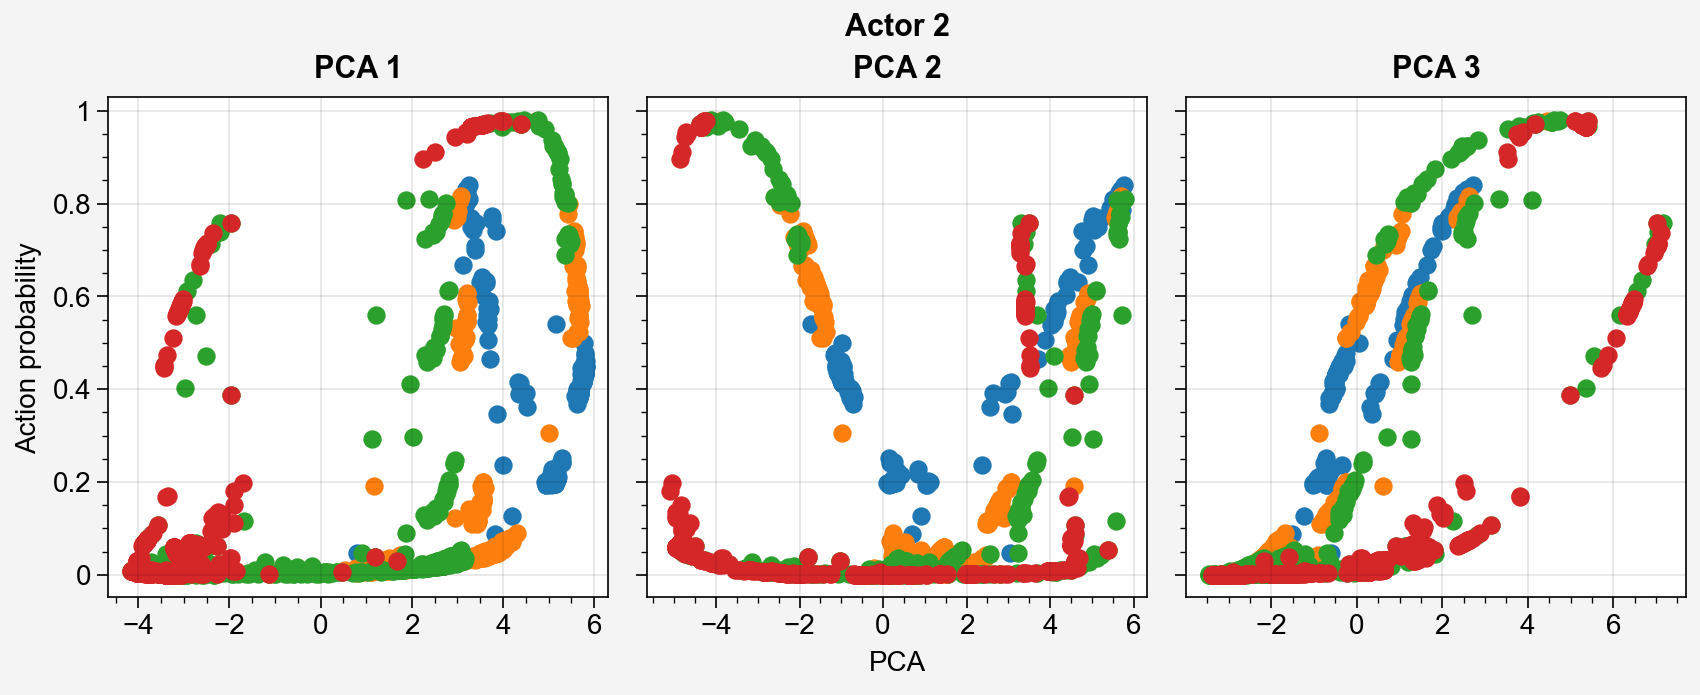

In [102]:
fig, ax = pplt.subplots(ncols=3)
for i in range(3):
    for j, ep in enumerate(eps):
        pca_a = pca_as[ep]
        ap = res['action_probs'][ep][:, 1]
        ax[i].scatter(pca_a[:, i], ap, c=rgb_colors[j])

ax.format(xlabel='PCA', ylabel='Action probability', toplabels=['PCA 1', 'PCA 2', 'PCA 3'],
          suptitle='Actor 2')

In [103]:
import plotly.graph_objects as go

eps = [12, 13, 14]
traces = []

step1 = 100
step2 = 130
colors = ['darkblue',  'red', 'green']
for i, ep in enumerate(eps):
    um_a = um_as[ep]
    x, y, z = um_a[step1:step2, 0], um_a[step1:step2, 1], um_a[step1:step2, 2]
    t = np.arange(len(x))
    size = unnormalize_obs(res['obs'][ep], obs_rms)[:, 5]
    size = size[step1:step2] 
    # Create a trace for the line
    trace = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        # mode='lines',
        marker=dict(
            size=4,
            color=size,
            colorscale='Plasma',
            colorbar=dict(title='Size')
        ),
        line=dict(
            color=colors[i],
            width=2
        )
    )
    traces.append(trace)

# Create the layout
layout = go.Layout(
    title='3D Time Series Line Plot',
    width=800,
    height=800,
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    )
)

# Create the figure and add the trace
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

# Decoupling impulsivity and risk-aversion

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning:

WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.



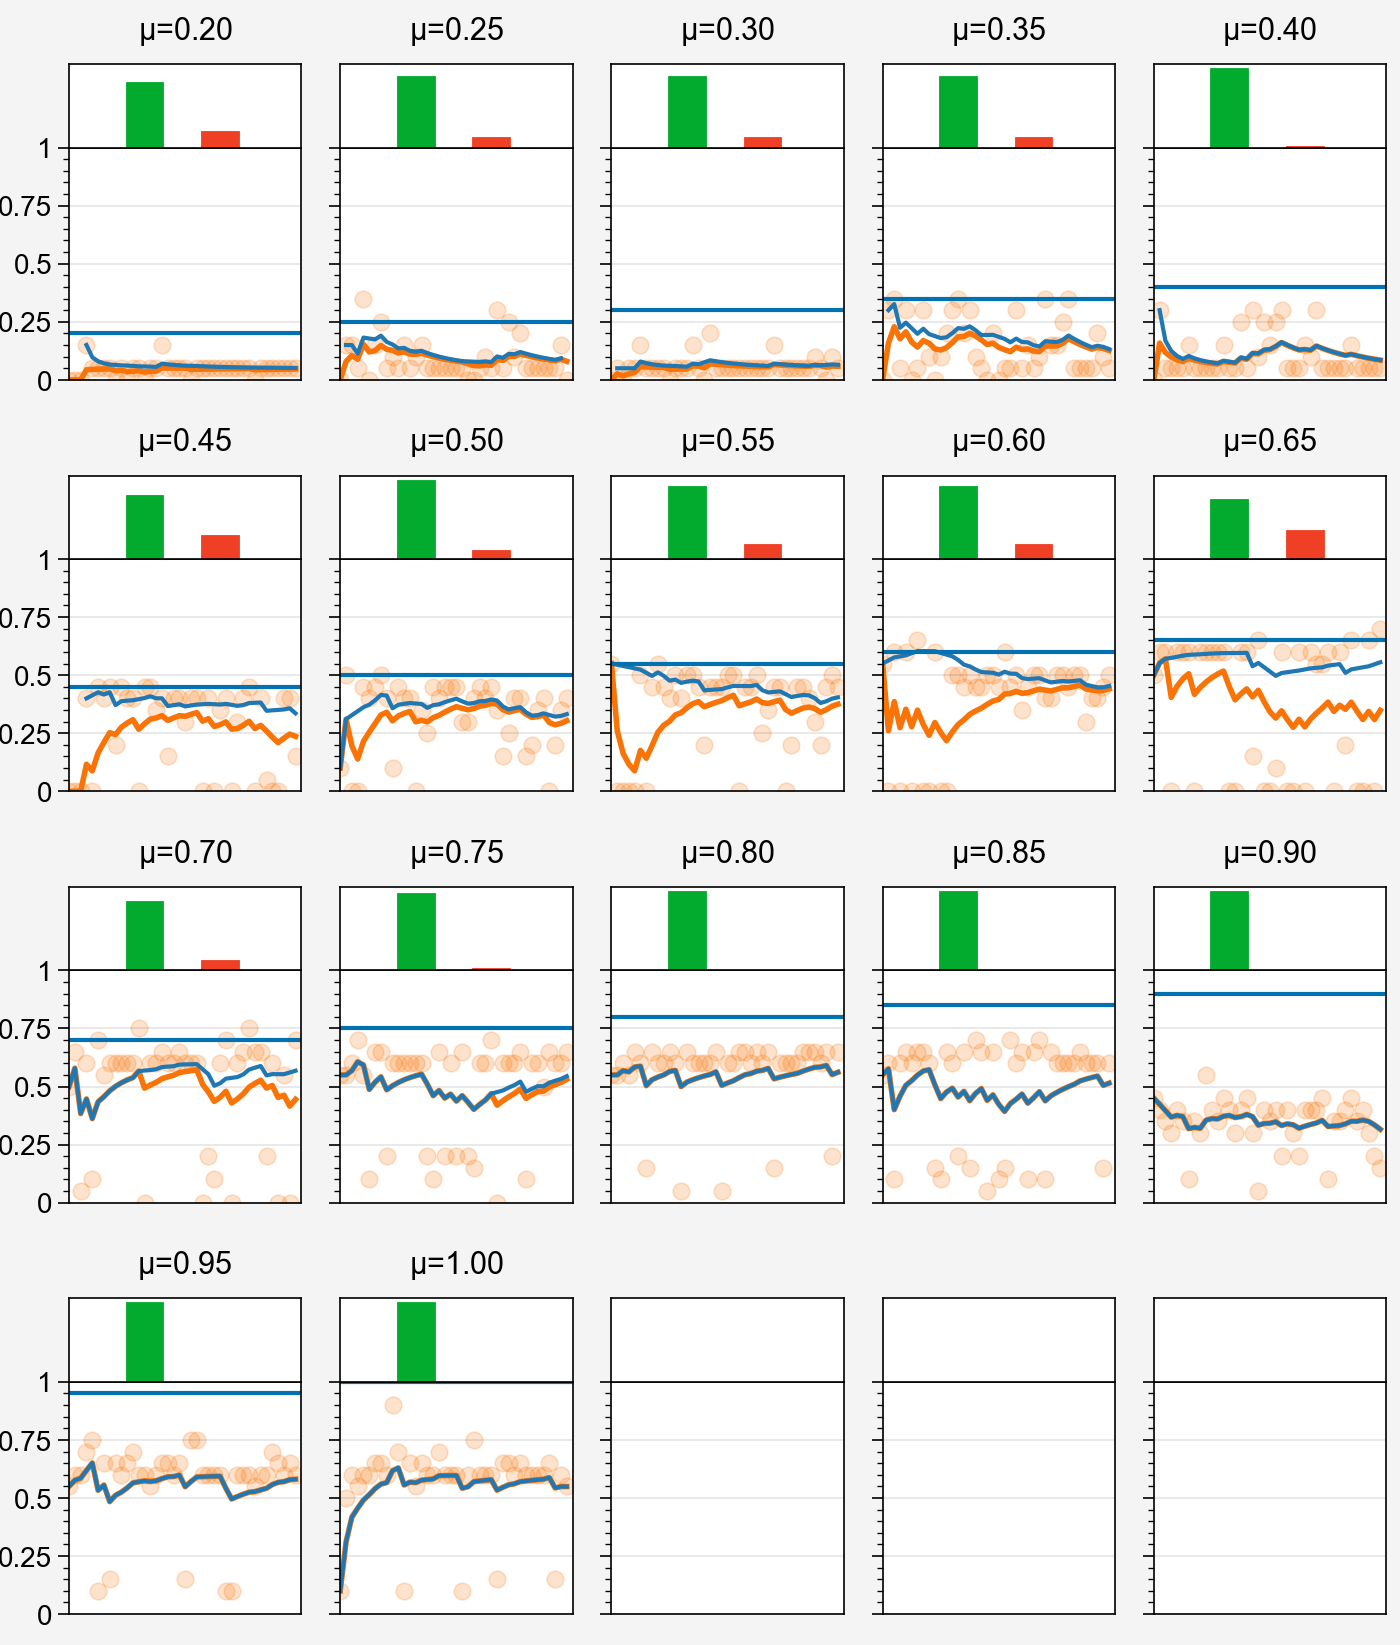

In [113]:
# model, (obs_rms, ret_rms) = \
#     torch.load(f'../saved_checkpoints/meta/meta_easyr4_0/60.pt')
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/p2n50pop0.1_1/160.pt')
res = evalu(model, obs_rms, deterministic=False)
res = reshape_parallel_evalu_res(res, meta_balloons=40)
plot_1colornfsize(res)

In [122]:
ep = 9
values = res['values'][ep].reshape(-1)
actions = res['actions'][ep].reshape(-1)
balloon_step = res['data']['balloon_step'][ep]

In [135]:
balloon_starts = []
delays = res['data']['inflate_delay'][ep]
for i in range(len(delays)):
    if i == 0:
        balloon_starts.append(delays[i])
    else:
        balloon_starts.append(balloon_step[i-1] + 1 + delays[i])


In [136]:
len(balloon_starts)

[0,
 11,
 24,
 37,
 50,
 63,
 76,
 89,
 101,
 114,
 127,
 140,
 153,
 166,
 179,
 191,
 204,
 217,
 221,
 235,
 248,
 261,
 264,
 277,
 289,
 302,
 315,
 327,
 340,
 352,
 364,
 377,
 391,
 404,
 409,
 423,
 438,
 452,
 466,
 480]

In [132]:
len(res['data']['inflate_delay'][ep])

40

In [134]:
len(res['data']['balloon_step'][ep])

40

In [126]:
np.argmax(actions[10:] == 1)

0

In [128]:
actions[10]

1

In [129]:
actions[10:]

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [110]:
t = 30
rew = res['rewards'][9][t:]
ret = 0
discount = 1
for r in rew:
    ret = ret + r*discount
    discount = discount*0.99

In [111]:
ret

3.268222274080274